In [ ]:
!date

Thu Aug 19 18:21:11 UTC 2021


In [2]:
#Download datasets

import requests
import os


from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
	url = 'https://api.datacite.org/dois/'+doi+'/media'
	r = requests.get(url).json()
	netcdf_url = r['data'][0]['attributes']['url']
	r = requests.get(netcdf_url,stream=True)
	#Set file name
	fname = doi.split('/')[-1]+ext
	#Download file with progress bar
	if r.status_code == 403:
		print("File Unavailable")
	if 'content-length' not in r.headers:
		print("Did not get file")
	else:
		with open(fname, 'wb') as f:
			total_length = int(r.headers.get('content-length'))
			pbar = tnrange(int(total_length/1024), unit="B")
			for chunk in r.iter_content(chunk_size=1024):
				if chunk:
					pbar.update()
					f.write(chunk)
		return fname


#10x VMH data
#metadata.csv
download_file('10.22002/D1.2065','.gz')

#tenx.mtx (log counts)
download_file('10.22002/D1.2072','.gz')


os.system("gunzip *.gz")

os.system("mv D1.2065 metadata.csv")
os.system("mv D1.2072 tenx.mtx")

/home/tchari/miniconda3/envs/mcml3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/940 [00:00<?, ?B/s]

  0%|          | 0/104912 [00:00<?, ?B/s]

0

In [3]:
#Read in files from NCBI GEO for Integrated Utero E10.5 dataset
!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_GSM5068636-GSM5068641_scRNA.MetaData.105.csv.gz
!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_GSM5068636-GSM5068641_scRNA.normalized.assay105.csv.gz
!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_GSM5068636-GSM5068641_scRNA.integrated.scaled.assay105.csv.gz

# !wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_scRNA.MetaData.85.csv.gz
# !wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_scRNA.normalized.assay85.csv.gz
#os.system("gunzip *.gz")

#integrated.scaled.assay105

In [4]:
!git clone https://github.com/hhcho/densvis.git

Cloning into 'densvis'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 145 (delta 78), reused 95 (delta 38), pack-reused 0
Receiving objects: 100% (145/145), 412.94 KiB | 0 bytes/s, done.
Resolving deltas: 100% (78/78), done.


In [7]:
%cd ./densvis/densne/

/home/tchari/CBP_2021/notebooks/densvis/densne


In [8]:
!g++ sptree.cpp densne.cpp densne_main.cpp -o den_sne -O2
import densne

In [9]:
%cd ../../

/home/tchari/CBP_2021/notebooks


In [6]:
!gunzip *.gz

gzip: *.gz: No such file or directory


In [8]:
!git clone https://github.com/pachterlab/CBP_2021.git

Cloning into 'CBP_2021'...
remote: Enumerating objects: 416, done.
remote: Counting objects: 100% (416/416), done.
remote: Compressing objects: 100% (374/374), done.
remote: Total 416 (delta 247), reused 91 (delta 25), pack-reused 0
Receiving objects: 100% (416/416), 52.94 MiB | 20.66 MiB/s, done.
Resolving deltas: 100% (247/247), done.


In [10]:
%cd ./CBP_2021/scripts

/home/tchari/CBP_2021/notebooks/CBP_2021/scripts


In [9]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy==1.7.0rc1
!pip3 install --quiet umap-learn

     |████████████████████████████████| 127 kB 2.6 MB/s 
     |████████████████████████████████| 10.2 MB 3.0 MB/s 
     |████████████████████████████████| 69 kB 3.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


In [10]:
# !pip install tbb

## **Install Packages**

In [11]:
import networkx as nx
import anndata 
import pandas as pd
import numpy as np

import visualizations as vis
import tools as tl
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
import matplotlib.patches as patches
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)
#sns.set_style('white')


In [12]:
sc.set_figure_params(dpi=125)

In [13]:
def tsnelatentComp(scaled_mat, ndims=2, pcs=50, rounds = 3):
  """ Compute latent space representations as baseline for reconstruction abilities"""
  reducer = umap.UMAP(n_components = ndims) # random_state = state
	#densUMAP = umap.UMAP(n_components = ndims,densmap=True)
  tsne = TSNE(n_components = ndims) 

  latents = []
  latentLab = []
  latentType = []

  for i in range(rounds):
    tsvd = TruncatedSVD(n_components=pcs)
    x_pca = tsvd.fit_transform(scaled_mat)
  
    pcaUMAP = reducer.fit_transform(x_pca)
		#pcaDensUMAP = densUMAP.fit_transform(x_pca)

    pcaTSNE = tsne.fit_transform(x_pca)


    latents += [x_pca, pcaTSNE,pcaUMAP]
    latentLab += ['PCA 50D','PCA TSNE','PCA UMAP']
    latentType += ['50D','2D','2D']

  return latents,latentLab,latentType

In [14]:
def latentComp(scaled_mat, ndims=2, pcs=50, rounds = 3):
  """ Compute latent space representations as baseline for reconstruction abilities"""
  reducer = umap.UMAP(n_components = ndims) # random_state = state
	#densUMAP = umap.UMAP(n_components = ndims,densmap=True)
  tsne = TSNE(n_components = ndims) 

  latents = []
  latentLab = []
  latentType = []

  for i in range(rounds):
    tsvd = TruncatedSVD(n_components=pcs)
    x_pca = tsvd.fit_transform(scaled_mat)
  
    pcaUMAP = reducer.fit_transform(x_pca)
		#pcaDensUMAP = densUMAP.fit_transform(x_pca)




    latents += [x_pca, pcaUMAP]
    latentLab += ['PCA '+str(pcs)+'D','PCA UMAP']
    latentType += ['50D','2D']

  return latents,latentLab,latentType

In [15]:
def latentDistortComp(scaled_mat, ndims=2, pcs=[15,50,100], rounds = 3):
  """ Compute latent space representations as baseline for distortion incurred"""
  reducer = umap.UMAP(n_components = ndims) # random_state = state
	#densUMAP = umap.UMAP(n_components = ndims,densmap=True)
  tsne = TSNE(n_components = ndims) 

  latents = []
  latentLab = []
  latentType = []

  for i in range(rounds):

    for j in pcs:

      tsvd = TruncatedSVD(n_components=j)
      x_pca = tsvd.fit_transform(scaled_mat)
  
      pcaUMAP = reducer.fit_transform(x_pca)
		#pcaDensUMAP = densUMAP.fit_transform(x_pca)
      pcaTSNE = tsne.fit_transform(x_pca)




      latents += [x_pca, pcaTSNE, pcaUMAP]
      latentLab += ['PCA '+str(j)+'D','PCA '+str(j)+'D t-SNE','PCA '+str(j)+'D UMAP']
      latentType += [str(j)+'D','2D','2D']

    pcaUMAP = reducer.fit_transform(scaled_mat)
		#pcaDensUMAP = densUMAP.fit_transform(x_pca)
    pcaTSNE = tsne.fit_transform(scaled_mat)

    tsvd = TruncatedSVD(n_components=2)
    x_pca = tsvd.fit_transform(scaled_mat)

    latents += [x_pca, pcaTSNE, pcaUMAP]
    latentLab += ['PCA 2D', 't-SNE 2D','UMAP 2D']
    latentType += ['2D','2D','2D']

  return latents,latentLab,latentType

In [16]:
#Centroids of clusters/labels
def getCentroidDists(embed,clusType):
  clusters = np.unique(clusType)

  centroids = np.zeros((len(clusters),embed.shape[1]))

  for i in range(len(clusters)):

    sub_data = embed[clusType == clusters[i],:]
    centroid = sub_data.mean(axis=0)

    centroids[i,:] = list(centroid)

  dists = pairwise_distances(centroids,centroids,metric='l1')

  return dists

## **Find Equidistant Cliques for 10x VMH Neuron Dataset**

In [17]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '../..'

pcs = 50
n_latent = 50

In [23]:
count_mat = sio.mmread(data_path+'/tenx.mtx')
count_mat.shape

(41580, 1999)

In [24]:
#Center and scale log-normalized data
scaled_mat = scale(count_mat)

In [25]:
meta = pd.read_csv(data_path+'/metadata.csv',index_col = 0)
meta.head()

,sample_name,cell_barcode,cluster_color,cluster,cluster_id,cell_types,sex_label,batch_indices,cell_counts,n_genes,percent_mito,pass_count_filter,pass_mito_filter
0,10x_VMH_Female_Control_1,4_AAACCTGAGCGCCTCA,#9162FF,Nr5a1_4,24.0,undefined,F,0,1427.0,926,13.594954,True,False
1,10x_VMH_Female_Control_1,4_AAACCTGCACAGTCGC,#96FF2E,Tsix_Esr1_1,3.0,undefined,F,0,4508.0,2310,9.272405,True,False
2,10x_VMH_Female_Control_1,4_AAACCTGCAGATTGCT,#66ABC2,Dlk1_3,16.0,undefined,F,0,3447.0,1995,5.483029,True,False
3,10x_VMH_Female_Control_1,4_AAACCTGCATACTCTT,#96FF2E,Tsix_Esr1_1,3.0,undefined,F,0,7004.0,3286,4.483152,True,True
4,10x_VMH_Female_Control_1,4_AAACCTGGTCCGTTAA,#24EFCD,Scgn,20.0,undefined,F,0,2490.0,1492,9.277108,True,False


In [26]:
meta.sex_label.value_counts()[0]/meta.sex_label.value_counts()[1]

3.829829248460913

In [27]:
meta.cluster.value_counts()

Nr5a1_4          3827
Dlk1_3           2317
Satb2_2          2132
Dlk1_4           2124
Dlk1_1           2046
Dlk1_2           1830
Nr5a1_1          1794
Tsix_Esr1_1      1659
Nr5a1_Foxp2_2    1571
Satb2_1          1567
Nr5a1_Foxp2_1    1500
Dlk1_5           1487
Esr1_2           1390
Esr1_1           1310
Dlk1_6           1304
Nr5a1_3          1223
Esr1_5           1210
Nup62cl          1201
Esr1_4           1070
Esr1_3           1059
Nr5a1_7          1050
Nr5a1_10         1041
Nr5a1_9          1018
Nr5a1_2          1003
Nr5a1_5          1002
Nr5a1_8           838
Satb2_3           798
Scgn              514
Esr1_6            500
Nr5a1_6           195
Name: cluster, dtype: int64

In [28]:
lab1 = list(meta.cluster)
lab2 = list(meta.sex_label)
lab3 = list(meta.sample_name)


allLabs = np.array([lab1,lab2])

nanLabs = np.array([[np.nan]*len(lab1)])

#Shuffled labels for over-fitting check
shuff_lab1 = random.sample(lab1, len(lab1))  
shuff_lab2 = random.sample(lab2, len(lab2))  
shuff_allLabs = np.array([shuff_lab1,shuff_lab2])

clus_colors = list(pd.unique(meta.cluster_color))

sex_colors = ['#F8C471','#abacb7']

### **Look for cells that are equidistance from each other (approximately for a simplex)**

In [29]:
count_mat.shape

(41580, 1999)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [30]:
#Choose cell type
#clus = 'Nr5a1_4' #Dlk1_3  
clus = 'Esr1_6'

In [31]:
#Subset for one cell type (here choosing a smaller cluster)
sub_mat = count_mat[meta.cluster.isin([clus]),:]


sub_mat.shape

(500, 1999)

In [32]:
sub_dists = pairwise_distances(sub_mat) 
sub_dists.shape

(500, 500)

In [33]:
#Avg distance between cells
avg = np.mean(sub_dists)
avg

82.81166384314497

In [34]:
#Std dev of distance between cells
std = np.std(sub_dists)
std

6.044856811640766

Subset for cells within some fraction of std dev from the avg distance

In [35]:
thresh = 2.8 #2.5
low_values = sub_dists <= (avg+std/thresh)
high_values = sub_dists >= (avg-std/thresh)

known_values = high_values & low_values
known_values.shape

(500, 500)

Selected cells (from pairwise distances)

In [36]:
from matplotlib.patches import Rectangle

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
 <a list of 10 Text major ticklabel objects>)

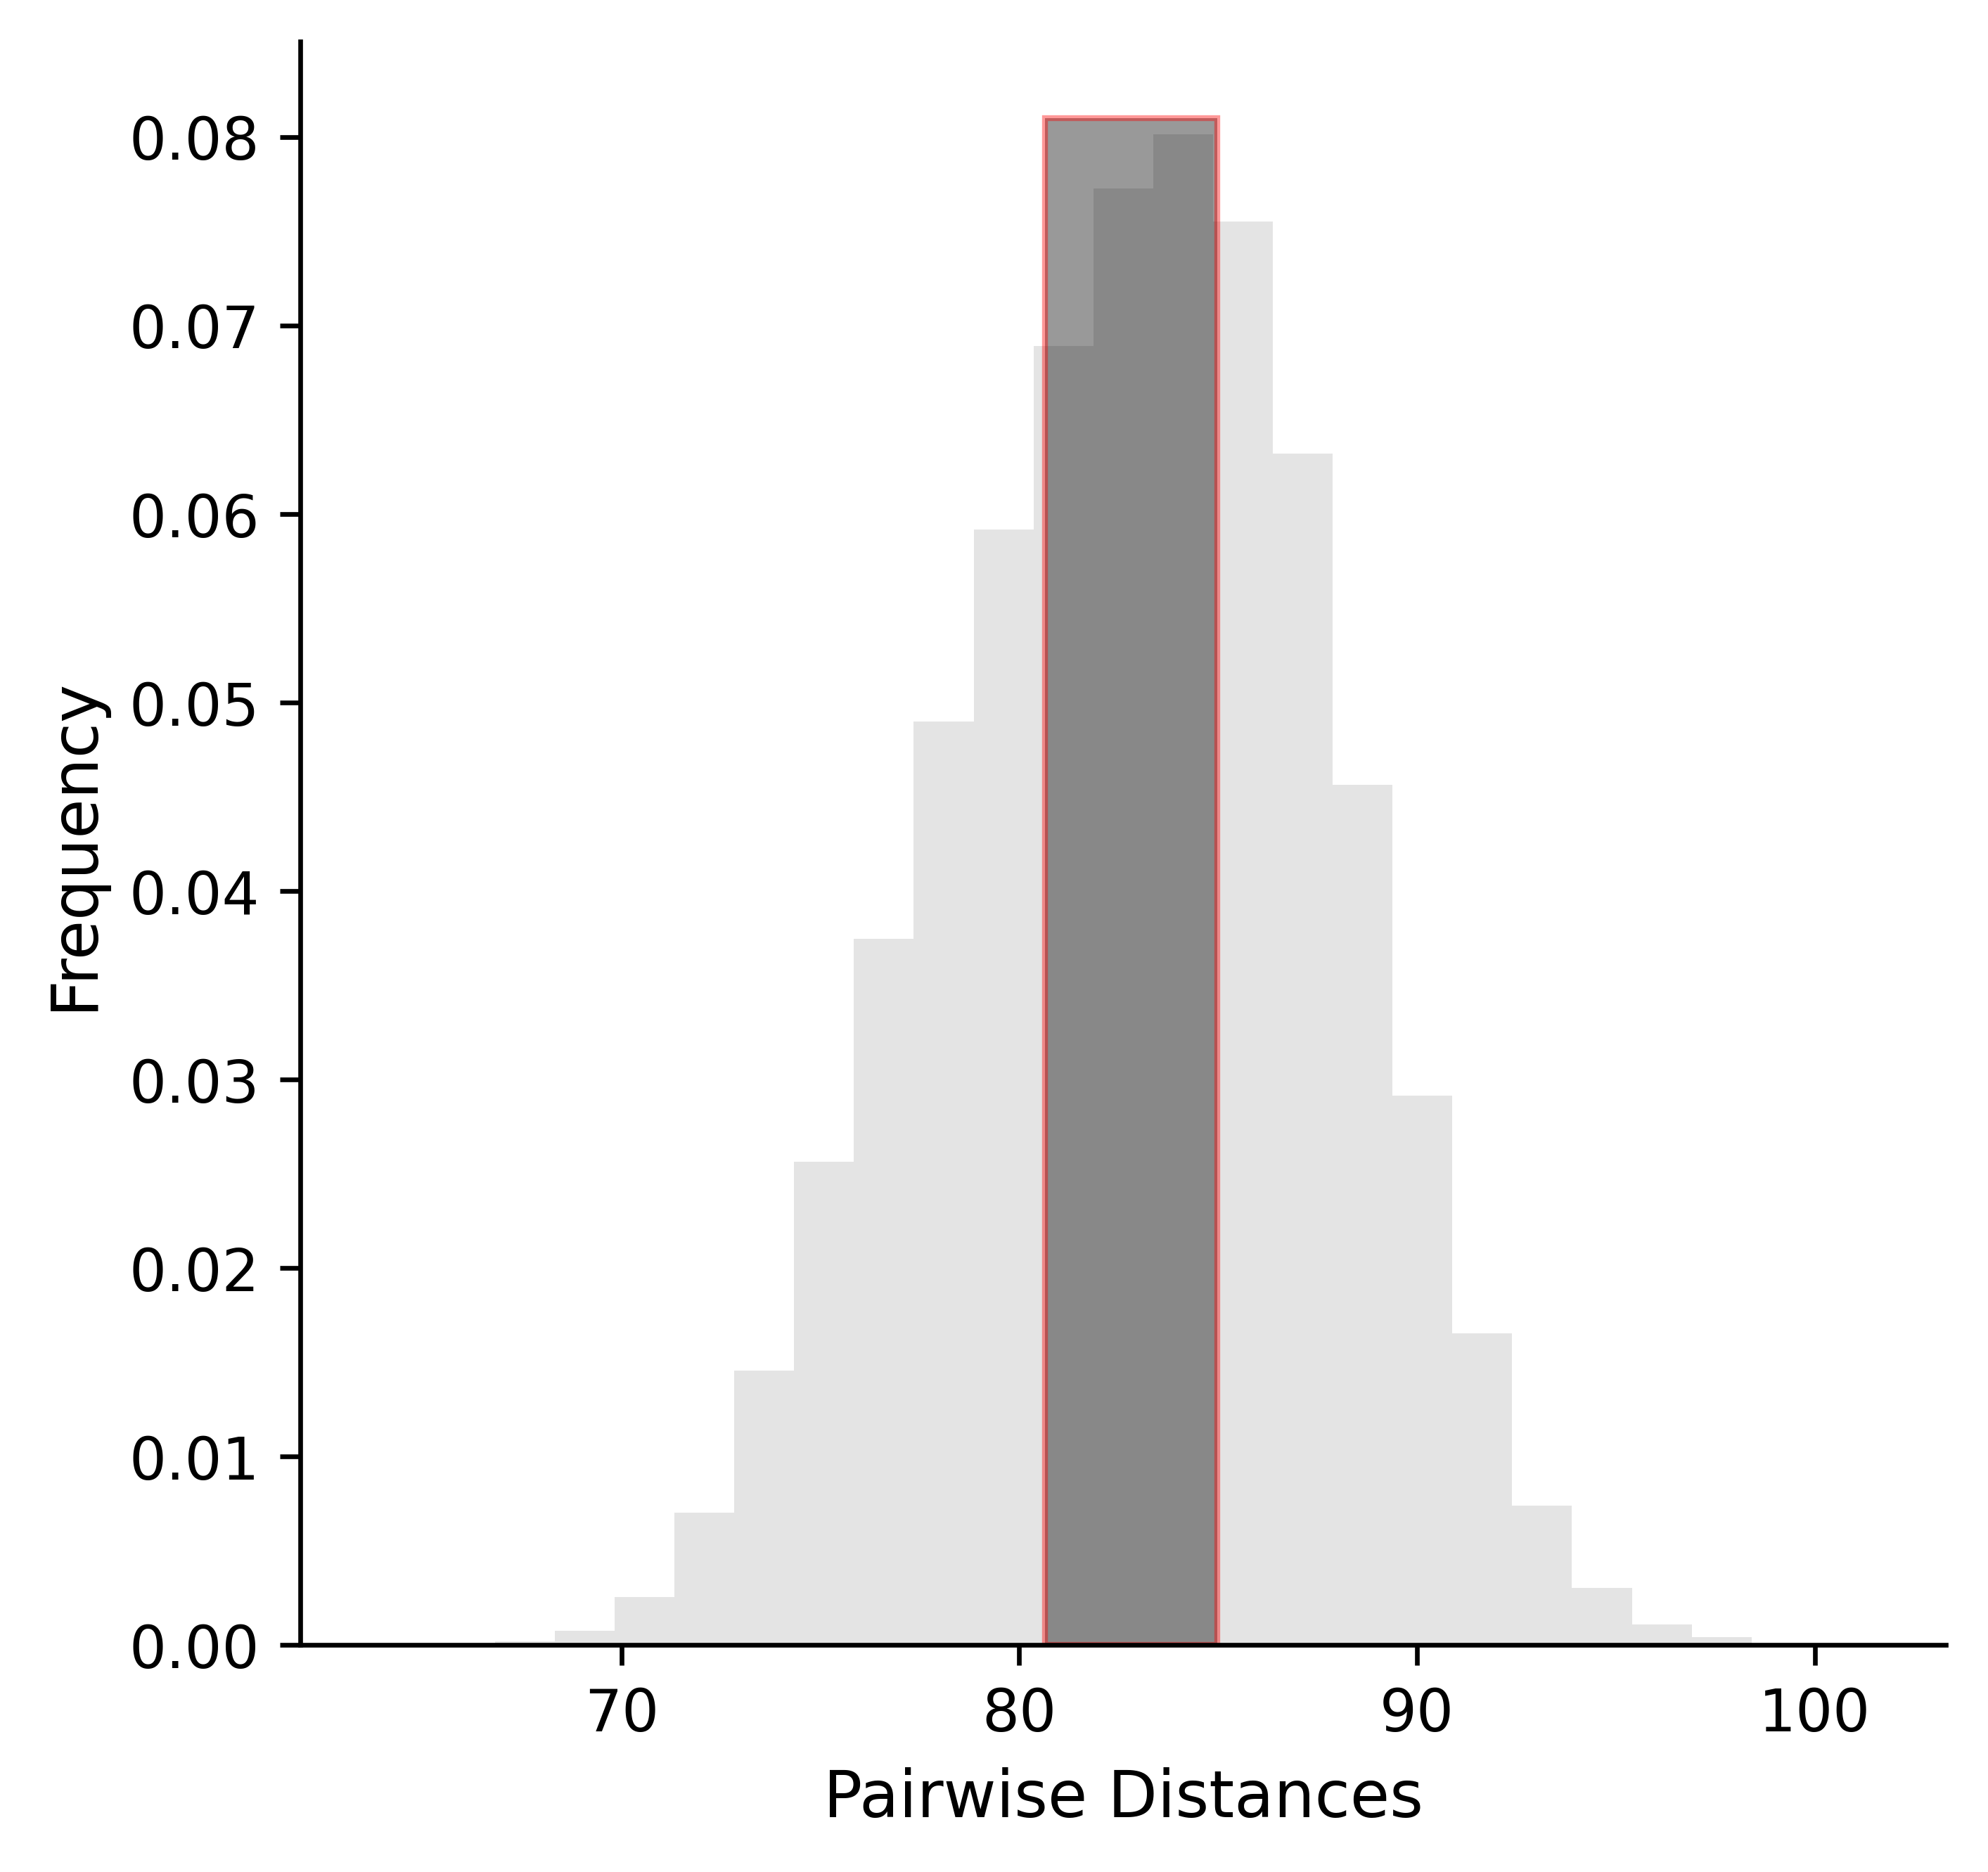

In [ ]:
plt.figure(figsize=(5,5),dpi=600)
plt.hist([i for i in sub_dists.flatten() if i!=0],density=True,bins=25,alpha=0.6,color='lightgrey')


# Add the patch to the Axes
plt.gca().add_patch(Rectangle((avg-std/thresh,0),2*(std/thresh),.081,linewidth=1,edgecolor='red',facecolor='black',alpha=0.4))

plt.grid(None)

ax = plt.gca()

#Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
 
plt.xlabel("Pairwise Distances",fontsize=11)
plt.ylabel("Frequency",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [37]:
#Bool matrix of where distances meet std dev criteria (are ~equidistant)
known_values

array([[False, False,  True, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [ True, False, False, ...,  True, False, False],
       ...,
       [False, False,  True, ..., False,  True, False],
       [False, False, False, ...,  True, False,  True],
       [ True, False, False, ..., False,  True, False]])

In [38]:
np.sum(known_values)

82140

Create graph

In [39]:
adjacency_matrix = known_values.astype(int)
adjacency_matrix

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 1, 0]])

In [40]:
rows, cols = np.where(adjacency_matrix == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
all_rows = range(0, adjacency_matrix.shape[0])
for n in all_rows:
  gr.add_node(n)

gr.add_edges_from(edges)

Find cliques

In [41]:
cliques = list(nx.find_cliques(gr))

In [42]:
#Look at number of cells in cliques (sizes)
np.unique([len(i) for i in cliques])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

Histogram of clique sizes (greater than two), with pairwise distance approximately around the average distance

In [43]:
cliqueSizes = pd.DataFrame()
cliqueSizes['size'] = [len(i) for i in cliques]

print(len(cliqueSizes))

cliqueSizes = cliqueSizes[cliqueSizes['size'] > 2]

#Number of unique cliques in total
print(len(cliqueSizes))

# valCounts = cliqueSizes['size'].value_counts().tolist()
# vals = cliqueSizes['size'].value_counts().index.tolist()

10375124
10375096


(array([      0.,  500000., 1000000., 1500000., 2000000., 2500000.,
        3000000., 3500000., 4000000.]),
 <a list of 9 Text major ticklabel objects>)

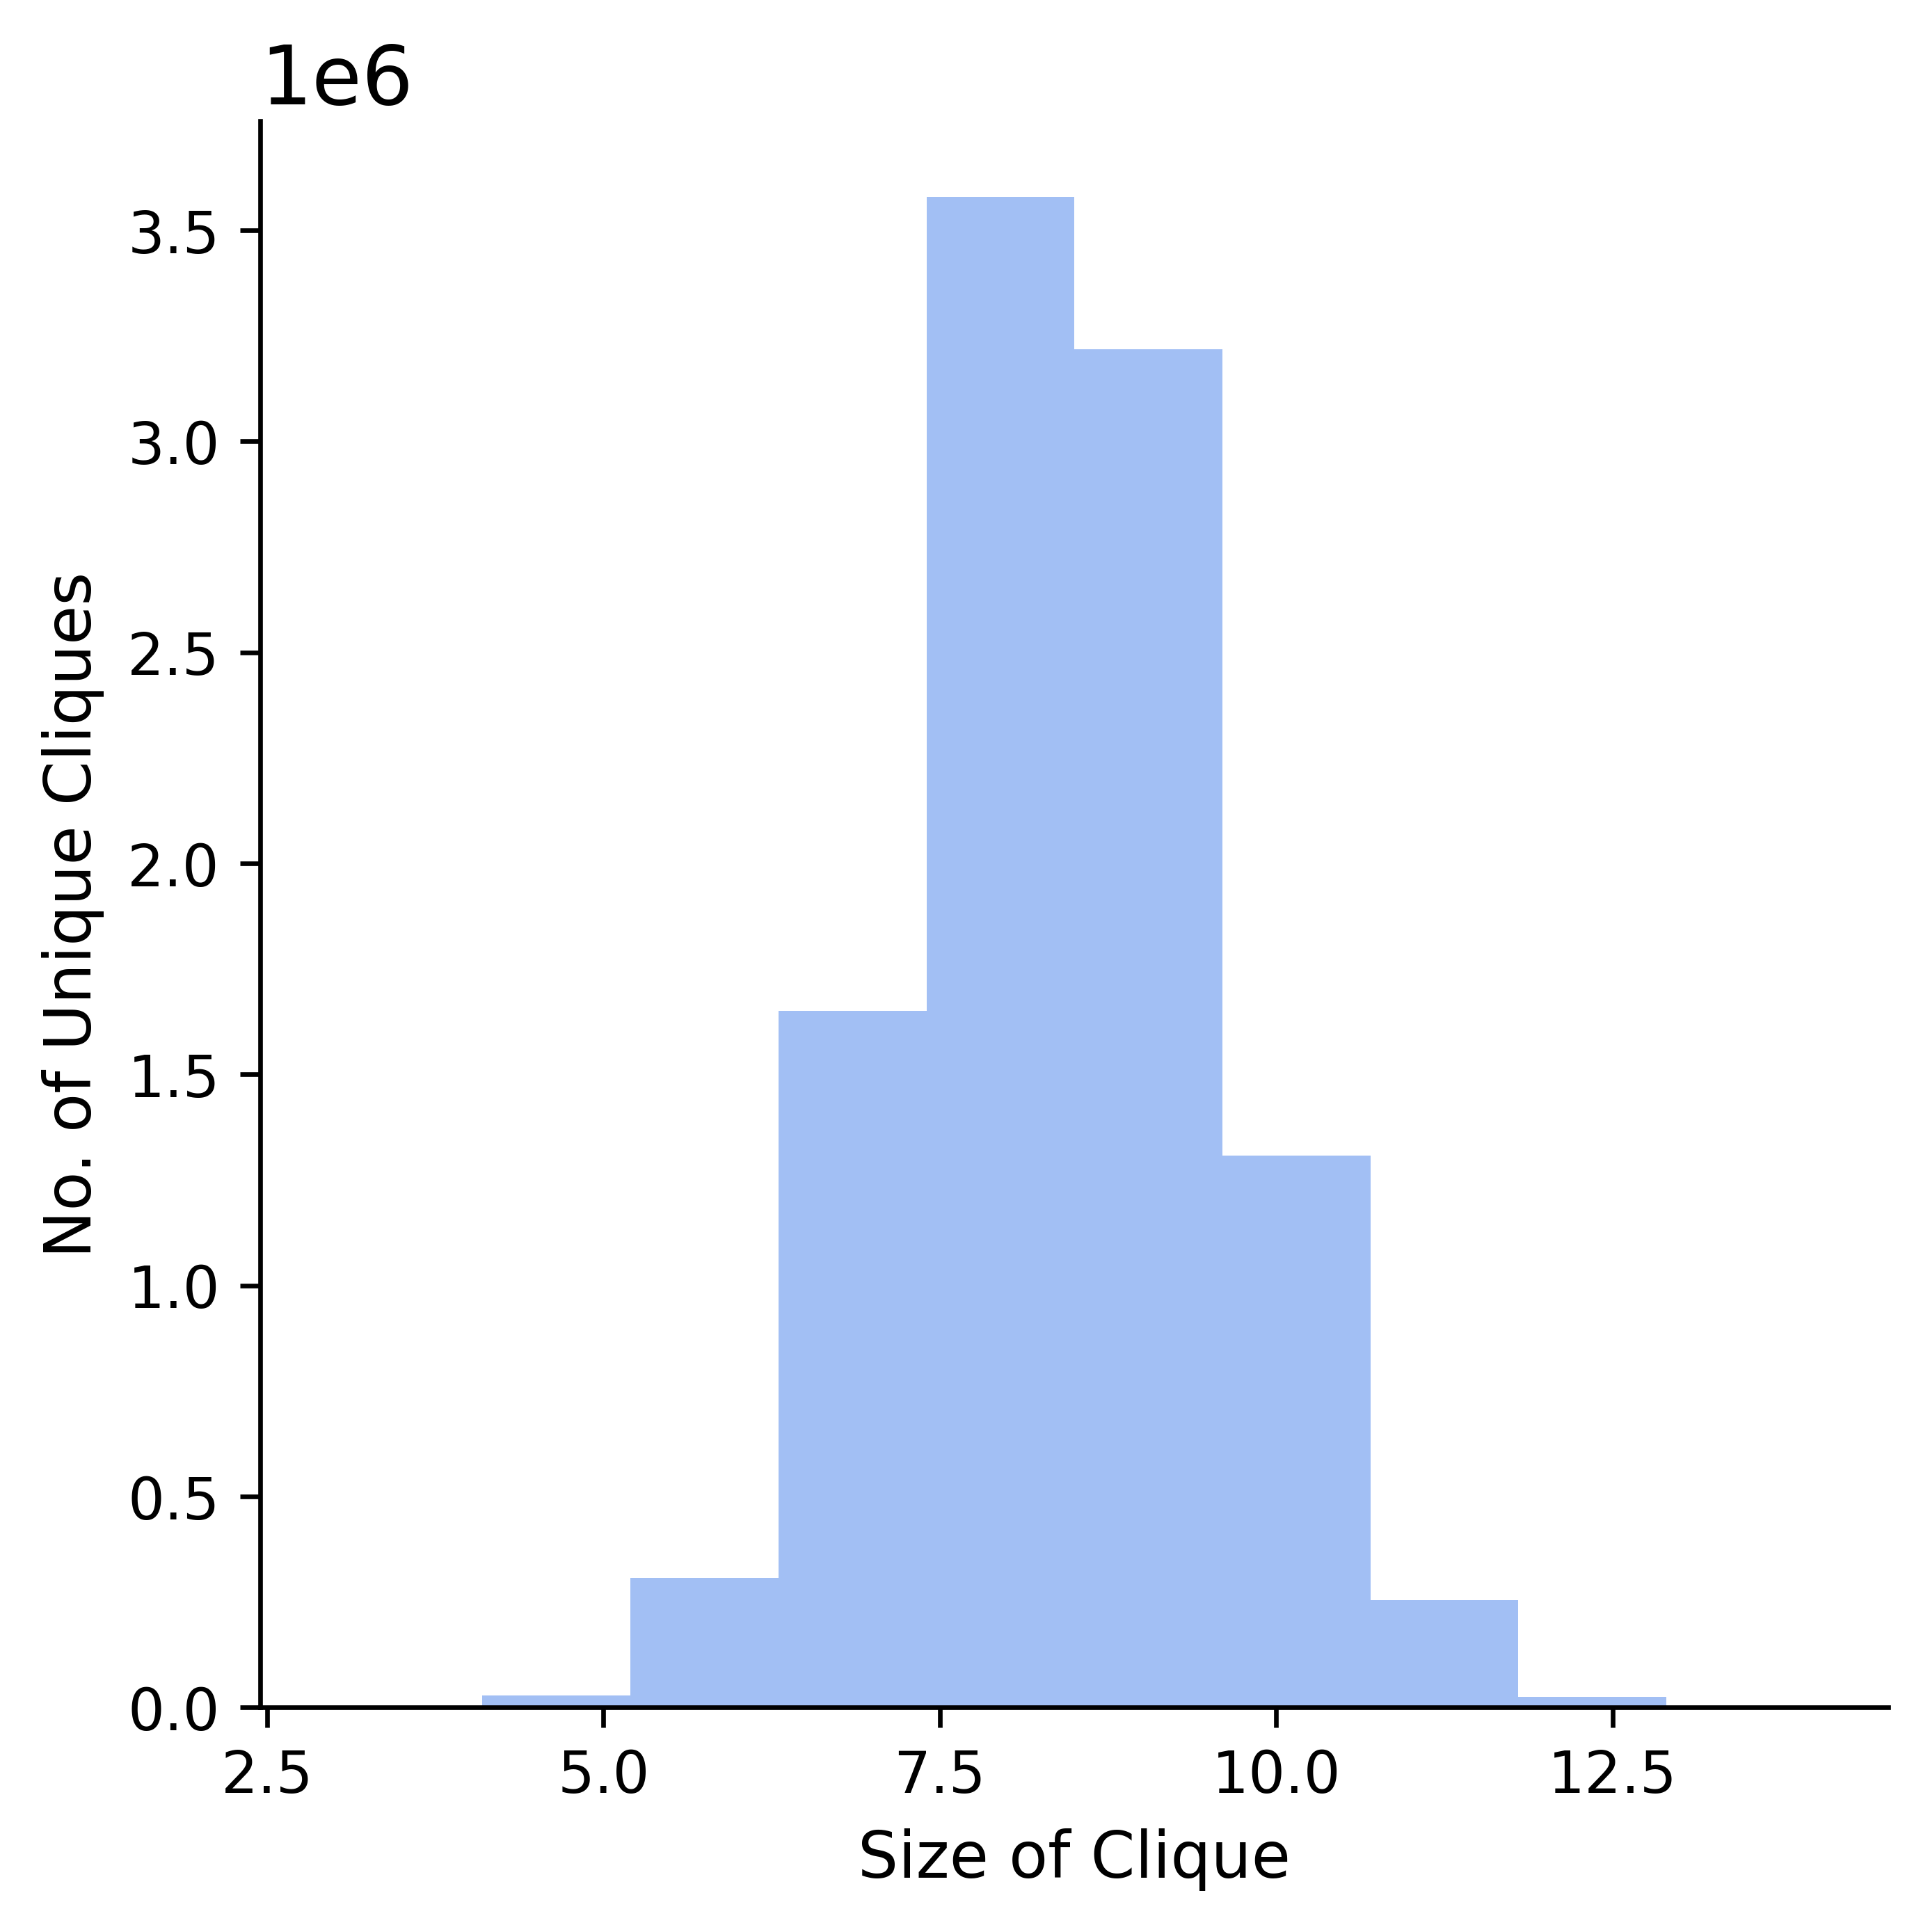

In [ ]:
plt.figure(figsize=(5,5),dpi=600)
#sns.barplot(x=vals, y=valCounts)
plt.hist(list(cliqueSizes['size']),alpha=0.6,color='cornflowerblue')

# Add the patch to the Axes

plt.grid(None)
ax = plt.gca()

#Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
 
plt.xlabel("Size of Clique",fontsize=11)
plt.ylabel("No. of Unique Cliques",fontsize=11) 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

### **Take cliques and compare variance in pairwise distances after dimensionality reduction**

In [44]:
#Get variance of pairwise distances between cells in given latent space
def getVar(latent,nodes):
  d = pairwise_distances(latent[nodes,:])
  d = d[d!=0]
  var = np.std(d)**2/np.mean(d)
  return var


In [45]:
#Get variance of pairwise distances between cells in given latent space
def getMaxMin(latent,nodes):
  d = pairwise_distances(latent[nodes,:])
  d = d[d!=0]
  ratio = np.max(d)/np.min(d)
  return ratio


In [46]:
#Get variance of pairwise distances between cell type centroids in given latent space
def getVarwithDist(dists,nodes):
  d = dists[nodes,:]
  d = d[:,nodes]
  d = d[d!=0]
  var = np.std(d)**2/np.mean(d)
  return var


In [47]:
#Get variance of pairwise distances between cells in given latent space
def getMaxMinwithDist(dists,nodes):
  d = dists[nodes,:]
  d = d[:,nodes]
  d = d[d!=0]
  ratio = np.max(d)/np.min(d)
  return ratio


In [48]:
#Get nonzero gene indices (which genes do the cliques express)
def getNonzero(latent,nodes):
  d = np.nonzero(np.any(latent[nodes,:] != 0, axis=0))[0]
  return d.tolist()

In [49]:
def getNeighMaxMin(latent,neighbors=10):
  n = neighbors
  neigh = NearestNeighbors(n_neighbors=n)
  neigh.fit(latent)

  #Get nearest neighbors for each cell
  kNeigh = neigh.kneighbors(latent)
  matNeigh = kNeigh[1]

  return matNeigh

Subset cliques because there are a lot of them

In [50]:
cliquesSub = [i for i in cliques if len(i) >= 12]
len(cliquesSub)

25593

In [51]:
# cliquesSub = cliques[5000:10000]

In [52]:
def getCliqueDF(cliquesSub):
  ambVars = [np.mean([getVar(sub_mat,i) for i in cliquesSub])]

  #Get variances of pairwise distances
  latVars = []
  latLabs = []

  for l in range(len(latents)):
    latVars += [np.mean([getVar(sublatents[l],i) for i in cliquesSub])]
    latLabs += [latentLab[l]]

  latVars += ambVars
  latLabs += ['Integrated-Scaled Ambient']

  #Get max/min ratio of pairwise distances
  ambVarsRatio = [np.mean([getMaxMin(sub_mat,i) for i in cliquesSub])]

  latVarsRatio = []
  latLabsRatio = []

  for l in range(len(latents)):
    latVarsRatio += [np.mean([getMaxMin(sublatents[l],i) for i in cliquesSub])]

  latVarsRatio += ambVarsRatio



  #Get max/min for cell + 10 NNs (nearest neighbors) in ambient versus latent spaces
  matNeigh = getNeighMaxMin(sub_mat,neighbors=10)
  ambVarsRatioKNN = [np.mean([getMaxMin(sub_mat,i) for i in matNeigh])]


  latVarsRatioKNN = []
  latLabsRatioKNN = []

  for l in range(len(latents)):
    matNeigh = getNeighMaxMin(sublatents[l],neighbors=10) #Could also try with the same NNs as in ambient space
    latVarsRatioKNN += [np.mean([getMaxMin(sublatents[l],i) for i in matNeigh])]

  latVarsRatioKNN += ambVarsRatioKNN

  res = pd.DataFrame()
  res['Vars'] = latVars
  res['Embed'] = latLabs
  res['LogVars'] = np.log(res['Vars'])
  res['Ratio'] = latVarsRatio
  res['RatioKNN'] = latVarsRatioKNN
  return res

### **PCA, t-SNE/UMAP, and PCA-tSNE/UMAP Distortions**

In [53]:
#Get latent spaces for comparison to ambient
latents,latentLab,latentType = latentDistortComp(scaled_mat, ndims=2, pcs=[15,50,100], rounds = 3)

In [54]:
sublatents = [i[meta.cluster.isin([clus]),:] for i in latents]




res10x = getCliqueDF(cliquesSub)
res10x.head()

,Vars,Embed,LogVars,Ratio,RatioKNN
0,0.520093,PCA 15D,-0.653747,3.052037,2.347171
1,6.896855,PCA 15D t-SNE,1.931066,168.707474,58.069157
2,1.194494,PCA 15D UMAP,0.177722,64.328323,24.159710
3,0.490751,PCA 50D,-0.711819,2.210660,1.758959
4,7.283585,PCA 50D t-SNE,1.985623,267.815613,50.184299


In [56]:
res10x.to_csv('distort10x.csv')



## **Cliques for Utero 10.5 Day Dataset**

In [18]:
def readLgMat(fname, data_path=data_path):

  col_names = pd.read_csv(data_path+fname, nrows=0).columns
  types_dict = {'Unnamed: 0': str}
  types_dict.update({col: np.float16 for col in col_names if col not in types_dict})

  chunk = pd.read_csv(data_path+fname,chunksize=1000,index_col=0,dtype=types_dict)
  counts = pd.concat(chunk)

  return counts

In [19]:
# fname = '/GSE149372_GSM5068636-GSM5068641_scRNA.integrated.scaled.assay105.csv' #'/GSE149372_GSM5068636-GSM5068641_scRNA.normalized.assay105.csv'

counts = readLgMat('/GSE149372_GSM5068636-GSM5068641_scRNA.integrated.scaled.assay105.csv',data_path)
counts.head()

,AAACCCAAGCCTCACG-1,AAACCCAAGCTCGACC-1,AAACCCAAGTTAACAG-1,AAACCCACACCATATG-1,AAACCCAGTCACGCTG-1,AAACCCAGTGCGTTTA-1,AAACCCAGTGGCTCTG-1,AAACCCATCCCATAGA-1,AAACGAAAGAAGCTCG-1,AAACGAAAGACTAAGT-1,...,TTTGGAGTCCCGAGTG-12,TTTGGTTAGTCTAACC-12,TTTGGTTCACAAAGCG-12,TTTGGTTGTATGAGGC-12,TTTGGTTTCGTGGCTG-12,TTTGTTGAGCAGCGAT-12,TTTGTTGCAGTCCGTG-12,TTTGTTGCAGTTCACA-12,TTTGTTGGTCGTGTTA-12,TTTGTTGTCCAACCAA-12
Hba-a1,-0.366699,-0.303711,-0.294678,2.830078,3.193359,-0.350342,2.978516,-0.426758,-0.448486,-0.161011,...,-0.313965,-0.265381,-0.435791,-0.354004,-0.579102,-0.314209,2.933594,-0.290771,-0.413330,-0.441895
Hbb-bh1,-0.391846,-0.164429,-0.295654,2.917969,3.232422,-0.368408,2.914062,-0.369385,-0.449463,-0.322998,...,-0.771973,-0.245239,-0.029694,-0.744141,-0.196533,-0.491455,2.970703,0.188110,-0.280029,-0.370117
Hba-x,0.409912,-0.145752,-0.494385,2.945312,3.166016,-0.245972,2.966797,-0.169556,-0.375977,-0.462646,...,-0.627441,-0.453369,-0.015388,-0.108826,0.317627,-0.010666,2.923828,-0.601562,-0.346924,0.152100
Gfod2,-0.947266,-0.459229,-0.254395,-0.182373,0.062988,0.299316,0.217407,-0.358154,-0.587402,-0.140625,...,0.168213,-0.163818,3.056641,-0.401123,1.704102,-0.355225,-0.213501,-0.847656,0.135742,1.581055
Mt1,-0.296143,-0.667480,-0.426270,1.979492,1.252930,-0.436035,2.855469,0.118347,-0.274170,1.331055,...,-0.440186,-0.308594,-0.475098,-0.369385,-0.430664,-0.371094,2.318359,-0.437744,-0.575684,-0.642090


In [20]:
cellMeta = pd.read_csv(data_path+'/GSE149372_GSM5068636-GSM5068641_scRNA.MetaData.105.csv')
print(cellMeta.head())

           Unnamed: 0 orig.ident  nCount_RNA  nFeature_RNA  samples Utero  \
0  AAACCCAAGCCTCACG-1      p10.5        4451          2028        1  ExUt   
1  AAACCCAAGCTCGACC-1      p10.5        8096          2793        1  ExUt   
2  AAACCCAAGTTAACAG-1      p10.5        6994          2760        1  ExUt   
3  AAACCCACACCATATG-1      p10.5       19467          3424        1  ExUt   
4  AAACCCAGTCACGCTG-1      p10.5        8205          1481        1  ExUt   

   percent.mt  integrated_snn_res.0.3  
0    5.526848                       7  
1    4.088439                       5  
2    3.345725                       5  
3    4.166025                       3  
4    1.962218                       3  


In [21]:
#Center and scale log-normalized data
count_mat = counts.values.T

In [22]:
adata = anndata.AnnData(X = count_mat)
adata.obs_names = list(counts.columns)
adata.var_names = list(counts.index)
adata.obs['Utero'] = pd.Categorical(cellMeta.Utero)
adata.obs['Cluster'] = pd.Categorical(cellMeta['integrated_snn_res.0.3'])
adata

AnnData object with n_obs × n_vars = 56528 × 2000
    obs: 'Utero', 'Cluster'

In [23]:
#In paper, use top 2000 HVGs and 15 PCs
adata.obsm['log'] = adata.X #Technically not just log- it's scaled+Centerd

sc.pp.scale(adata, max_value=10) #Already scaled
adata

AnnData object with n_obs × n_vars = 56528 × 2000
    obs: 'Utero', 'Cluster'
    var: 'mean', 'std'
    obsm: 'log'

In [24]:
count_mat = adata.obsm['log']
scaled_mat = adata.X

In [25]:
#Set colors for cell clusters
colors = np.random.rand(len(adata.obs['Cluster']),3)

In [26]:


labs = np.array([list(adata.obs['Cluster']),list(adata.obs['Utero'])])


In [27]:
adata.obs['Cluster'].value_counts()

0     6402
1     5258
2     5130
3     4659
4     4559
5     4345
6     4174
7     3809
8     3432
9     3028
10    2257
11    2213
12    2172
13    2025
14     770
15     683
16     641
17     412
18     355
19     204
Name: Cluster, dtype: int64

Make UMAPs

In [78]:
reducer = umap.UMAP(n_components = ndims, random_state = state)
#densUMAP = umap.UMAP(n_components = ndims, random_state = state,densmap=True)
tsne = TSNE(n_components = ndims, random_state = state) 

In [ ]:
# #PCA 
# tsvd = TruncatedSVD(n_components=pcs)
# x_pca = tsvd.fit_transform(scaled_mat)


# pcaUMAP = reducer.fit_transform(x_pca)


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [28]:
count_mat.shape

(56528, 2000)

In [29]:
#Choose cell type

clus = 4

In [30]:
#Subset for one cell type (here choosing a smaller cluster)
sub_mat = count_mat[adata.obs['Cluster'].isin([clus]),:]


sub_mat.shape

(4559, 2000)

In [31]:
sub_dists = pairwise_distances(sub_mat) 
sub_dists.shape

(4559, 4559)

In [32]:
#Avg distance between cells
avg = np.mean(sub_dists)
avg

40.93432

In [33]:
#Std dev of distance between cells
std = np.std(sub_dists)
std

9.844086

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05]),
 <a list of 6 Text major ticklabel objects>)

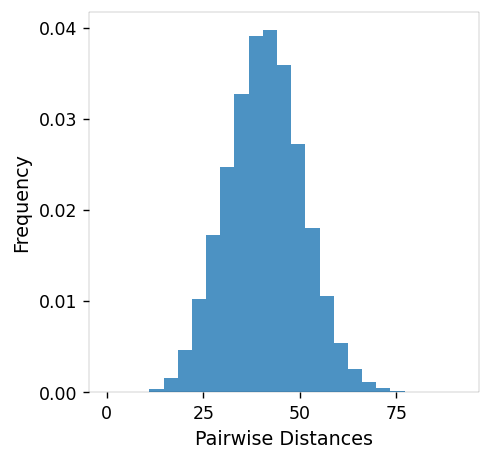

In [ ]:
plt.hist(sub_dists.flatten(),density=True,bins=25,alpha=0.8)
plt.grid(None)
plt.xlabel("Pairwise Distances",fontsize=11)
plt.ylabel("Frequency",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [ ]:
np.quantile(sub_dists.flatten(), 0.1)

28.097076416015625

In [ ]:
np.quantile(sub_dists.flatten(), 0.9)

53.53205490112305

Subset for cells within some fraction of std dev from the avg distance

In [34]:
thresh = 15#2.5
#avg = 25
low_values = sub_dists <= (avg+std/thresh)
high_values = sub_dists >= (avg-std/thresh)

known_values = high_values & low_values
known_values.shape

(4559, 4559)

In [35]:
#Bool matrix of where distances meet std dev criteria (are ~equidistant)
known_values

array([[False,  True, False, ..., False, False,  True],
       [ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False]])

In [36]:
np.sum(known_values)

1095876

Cells that are close and equidistant

In [37]:
low_values = sub_dists <= (28+std/thresh)
high_values = sub_dists >= (28-std/thresh)

known_values_low = high_values & low_values
np.sum(known_values_low)

495874

Cells that are farther, and equidistant

In [38]:
low_values = sub_dists <= (53+std/thresh)
high_values = sub_dists >= (53-std/thresh)

known_values_high = high_values & low_values
np.sum(known_values_high)

507990

(array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045]), <a list of 10 Text major ticklabel objects>)

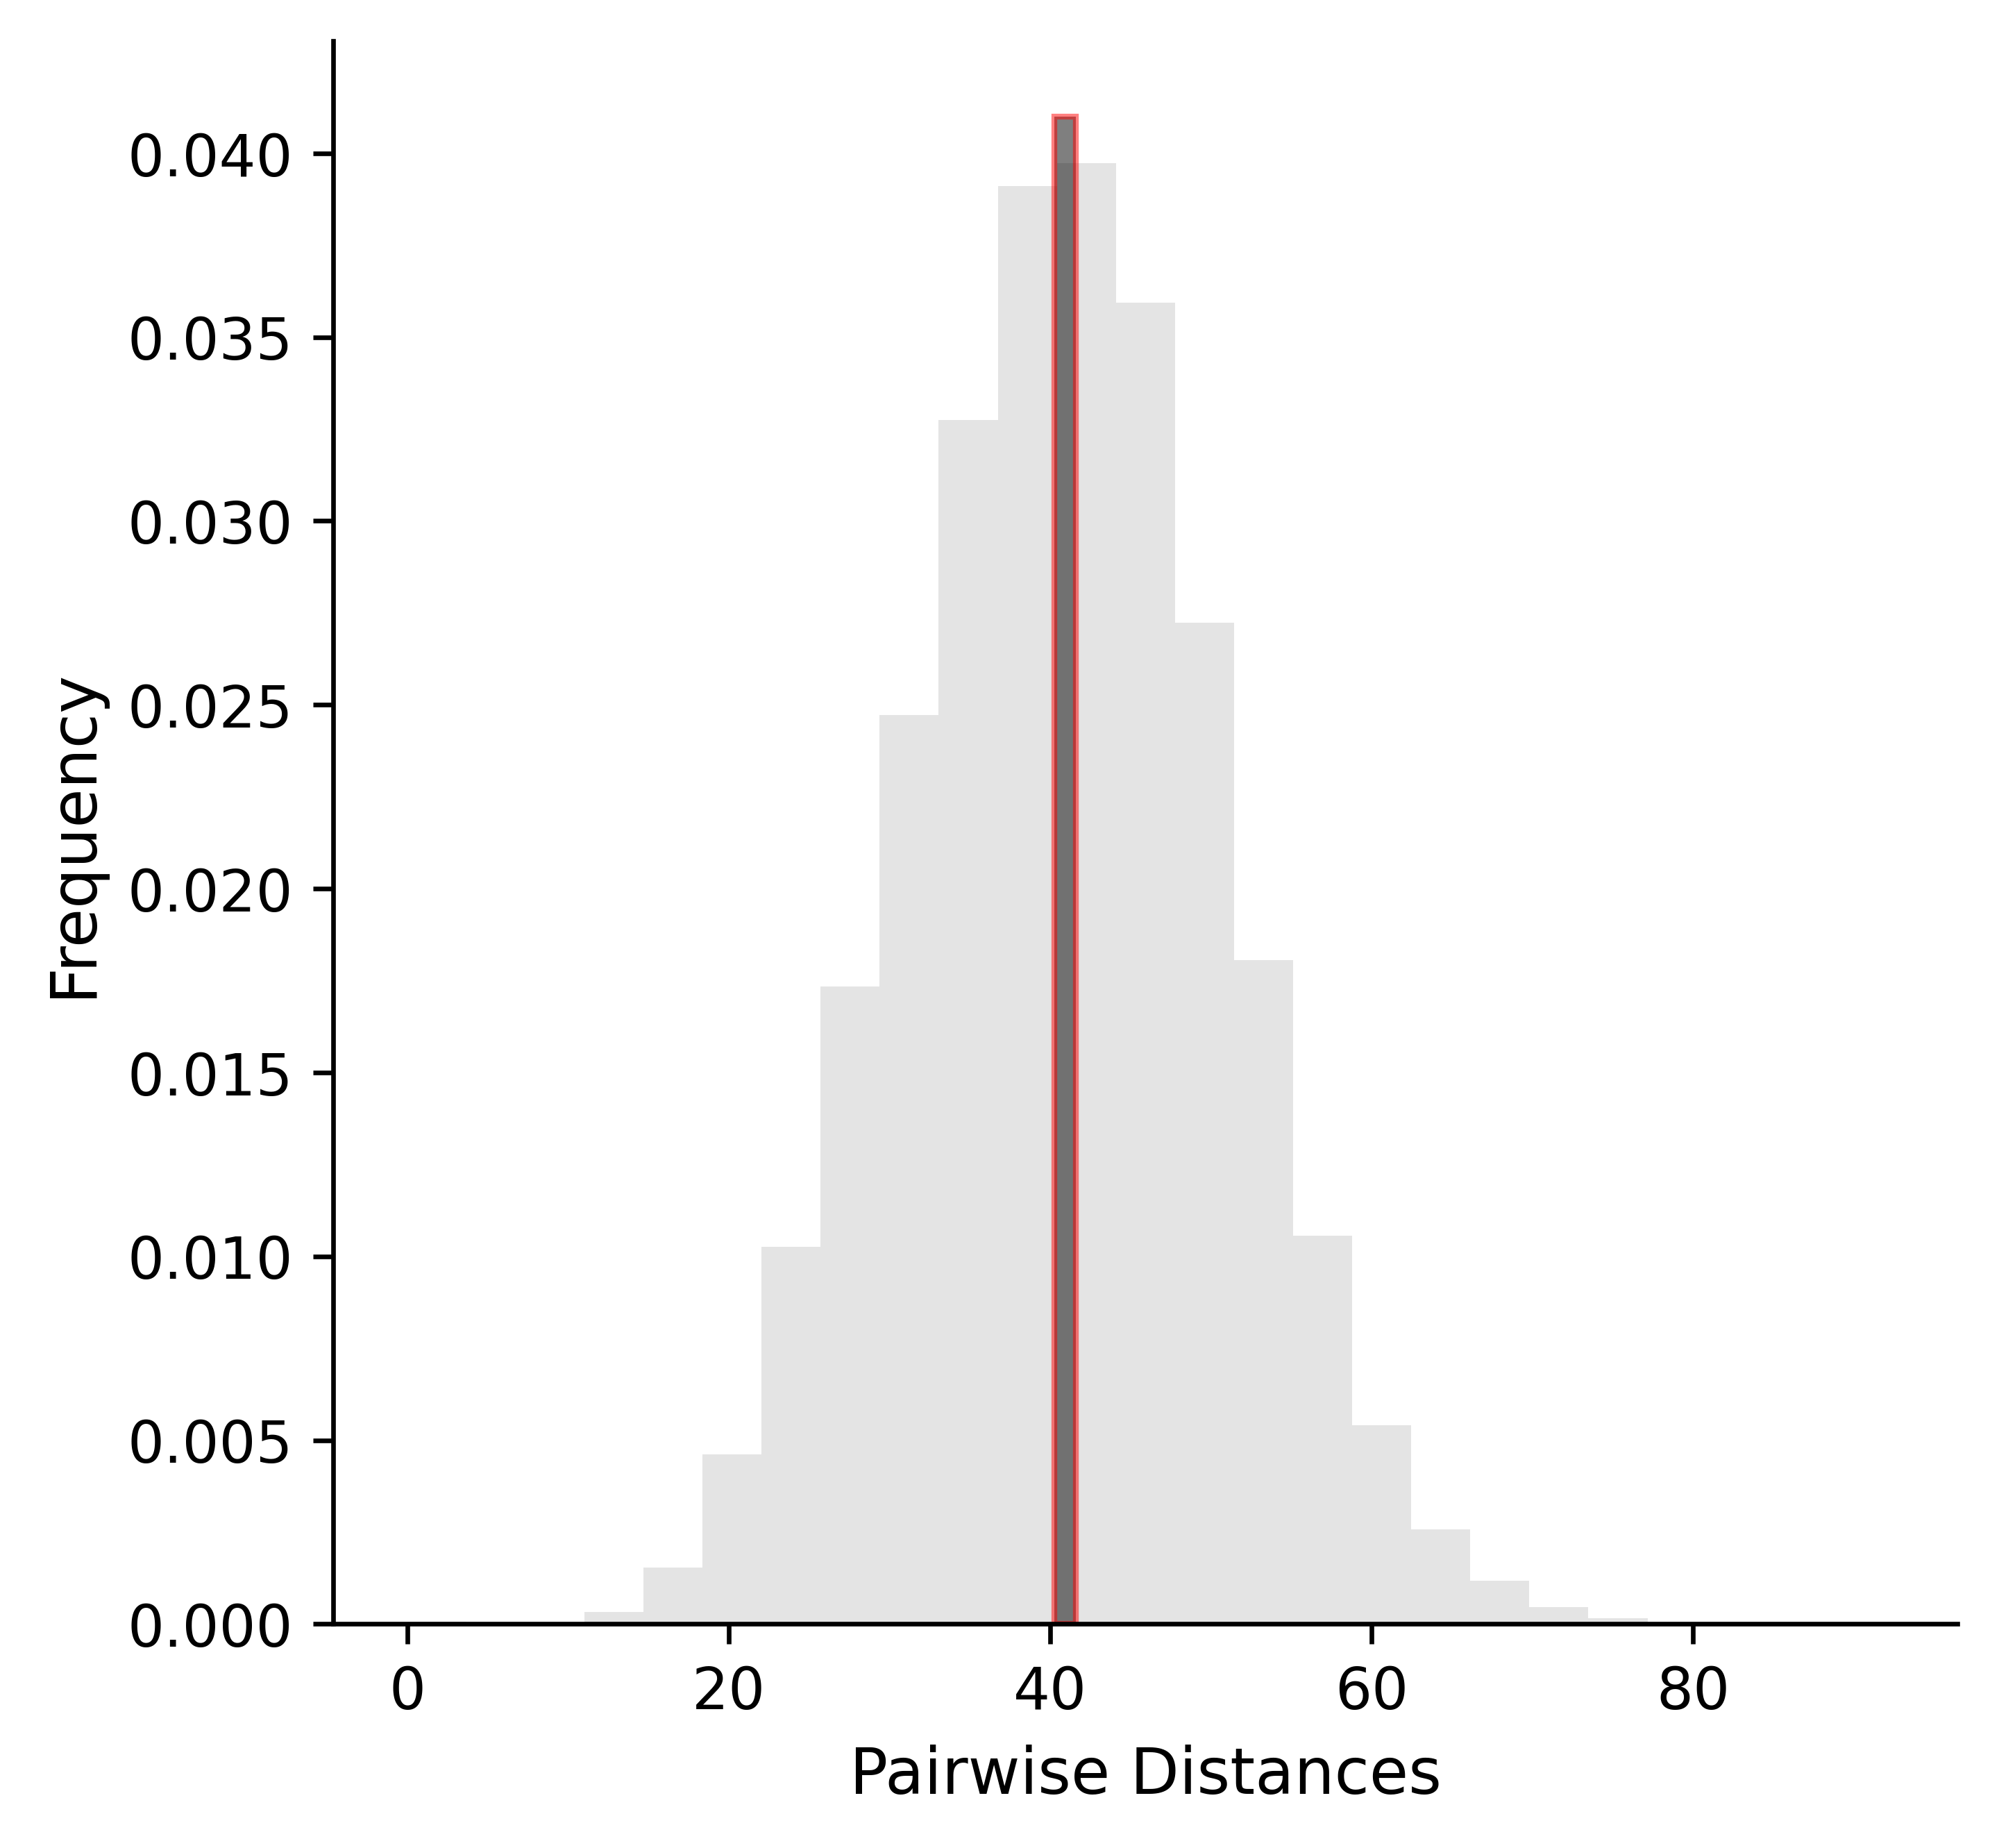

In [ ]:
plt.figure(figsize=(5,5),dpi=600)
plt.hist(sub_dists.flatten(),density=True,bins=25,alpha=0.6,color='lightgrey')


# Add the patch to the Axes
plt.gca().add_patch(Rectangle((avg-std/thresh,0),2*(std/thresh),.041,linewidth=1,edgecolor='red',facecolor='black',alpha=0.5))

plt.grid(None)
ax = plt.gca()

#Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
 
plt.xlabel("Pairwise Distances",fontsize=11)
plt.ylabel("Frequency",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

(array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045]), <a list of 10 Text major ticklabel objects>)

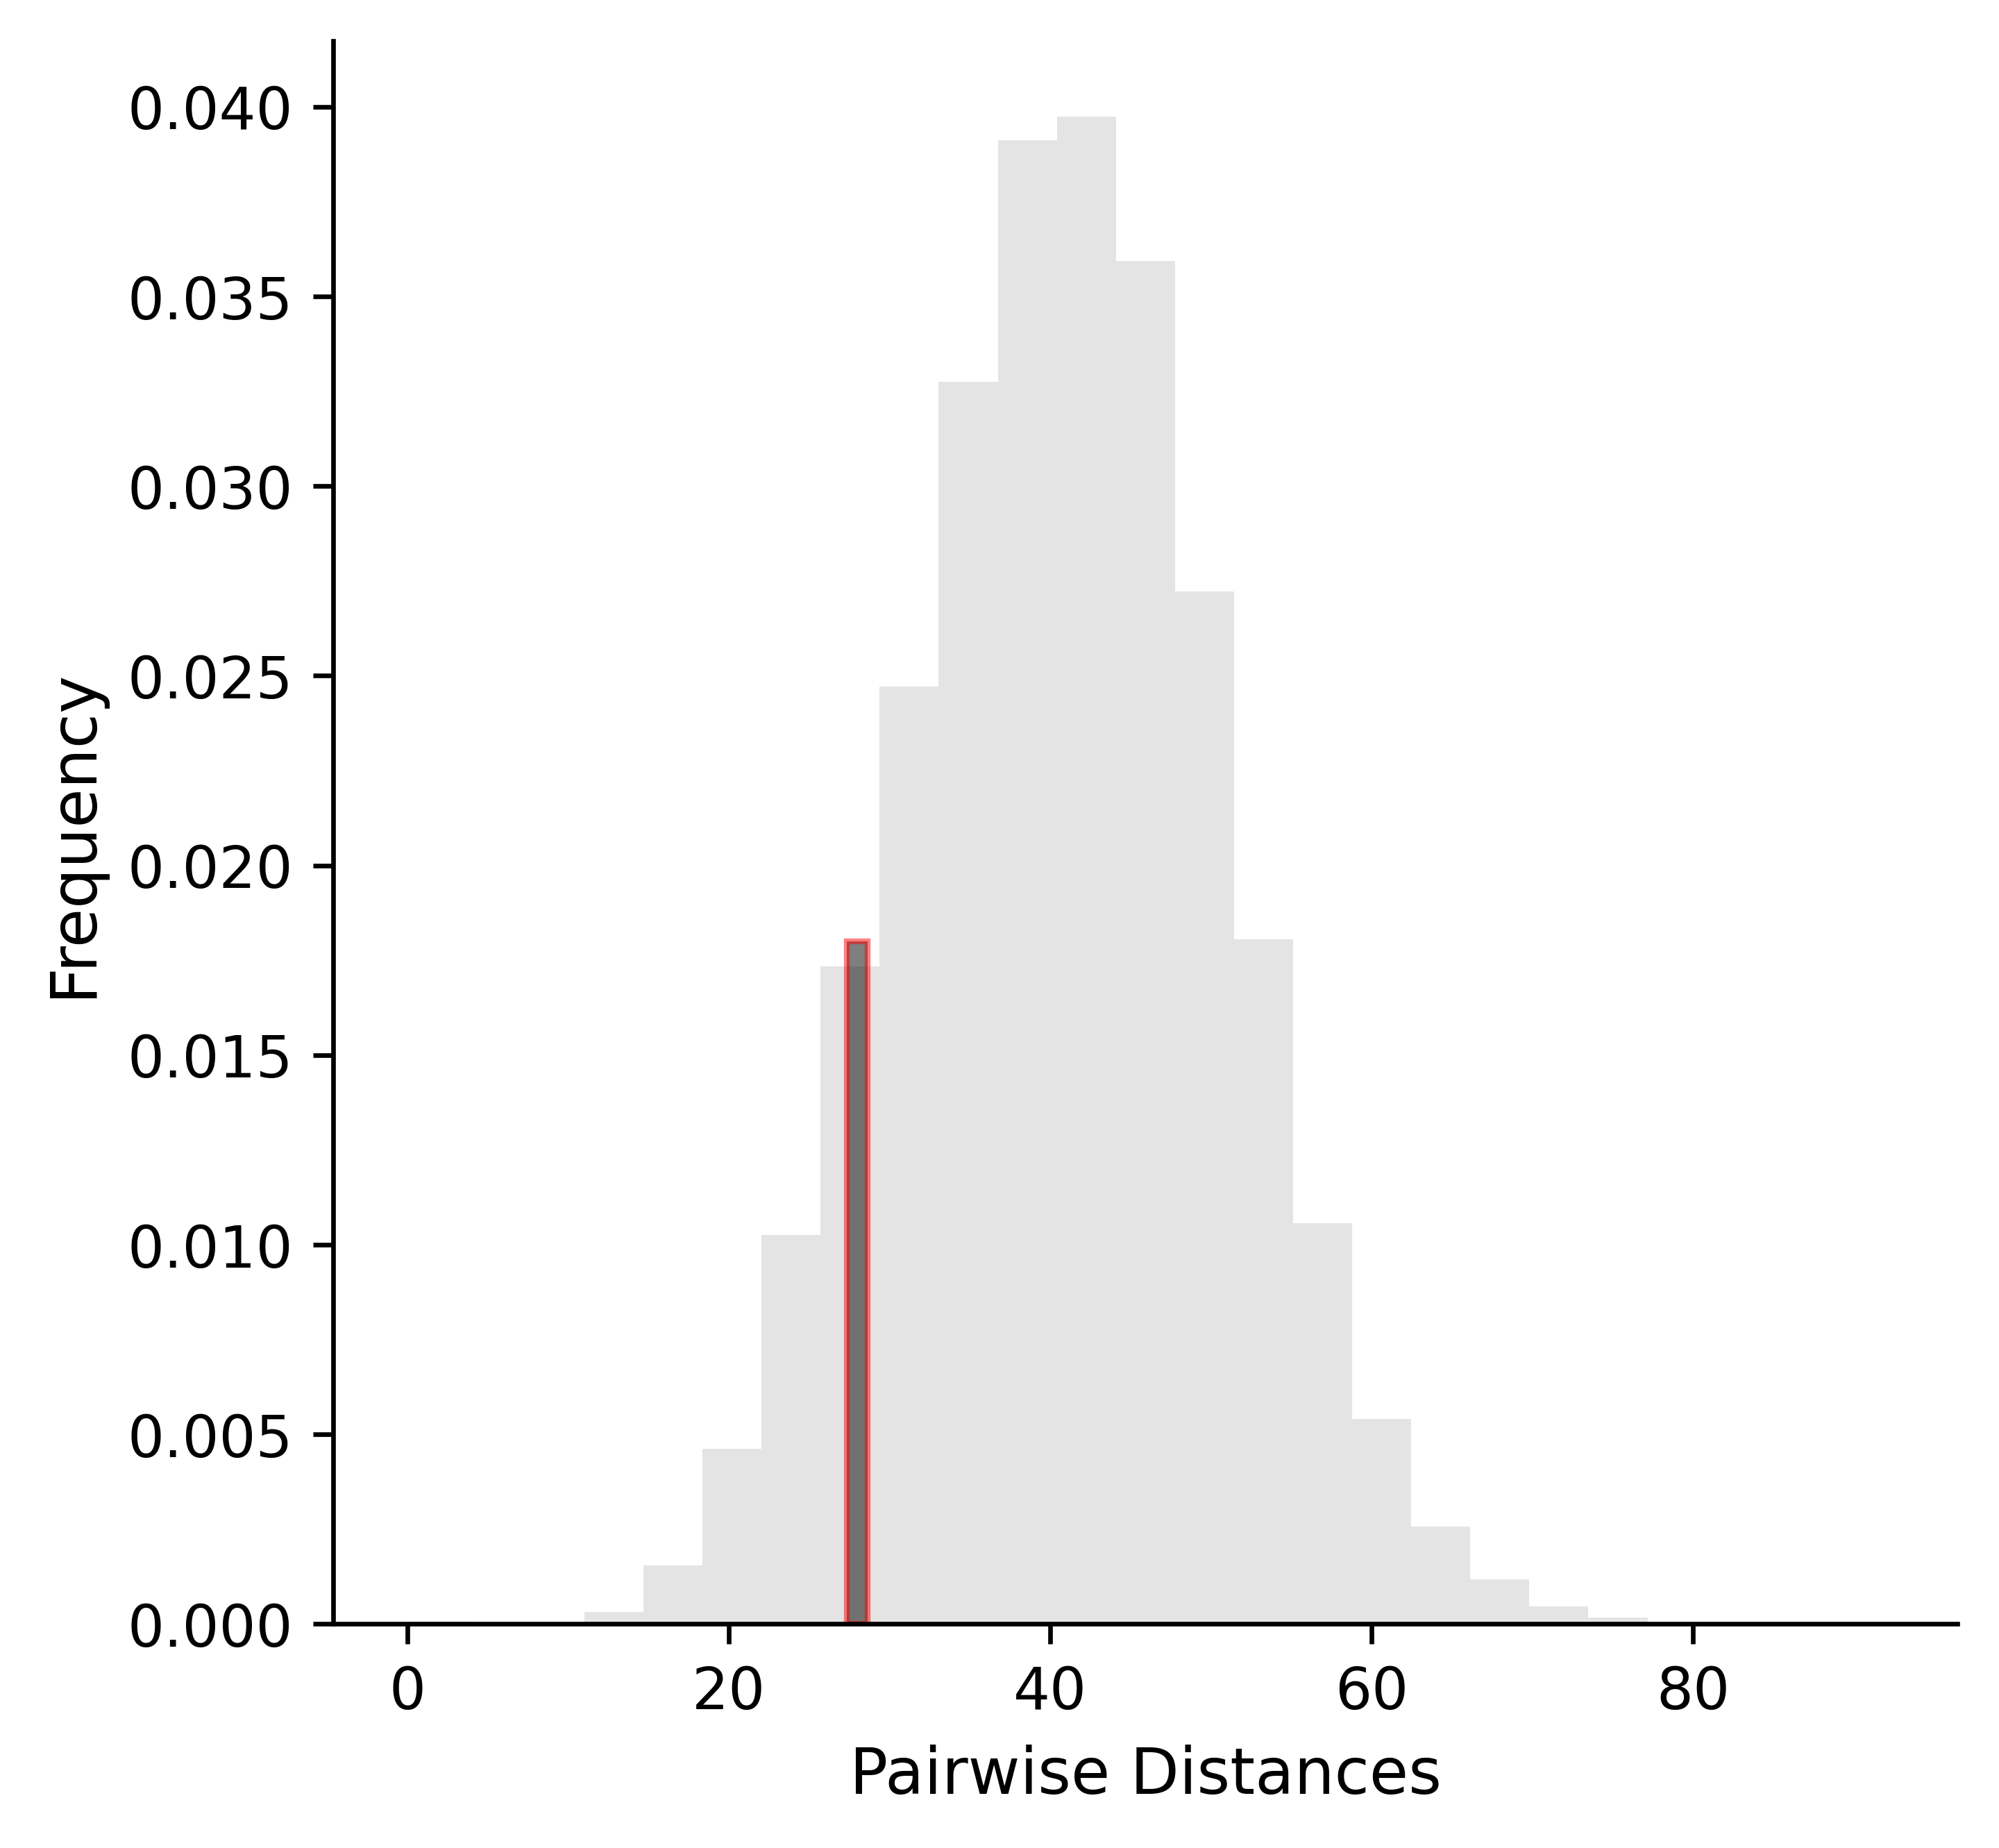

In [ ]:
plt.figure(figsize=(5,5),dpi=600)
plt.hist(sub_dists.flatten(),density=True,bins=25,alpha=0.6,color='lightgrey')


# Add the patch to the Axes
plt.gca().add_patch(Rectangle((28-std/thresh,0),2*(std/thresh),.018,linewidth=1,edgecolor='red',facecolor='black',alpha=0.5))

plt.grid(None)
ax = plt.gca()

#Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
 
plt.xlabel("Pairwise Distances",fontsize=11)
plt.ylabel("Frequency",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

(array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045]), <a list of 10 Text major ticklabel objects>)

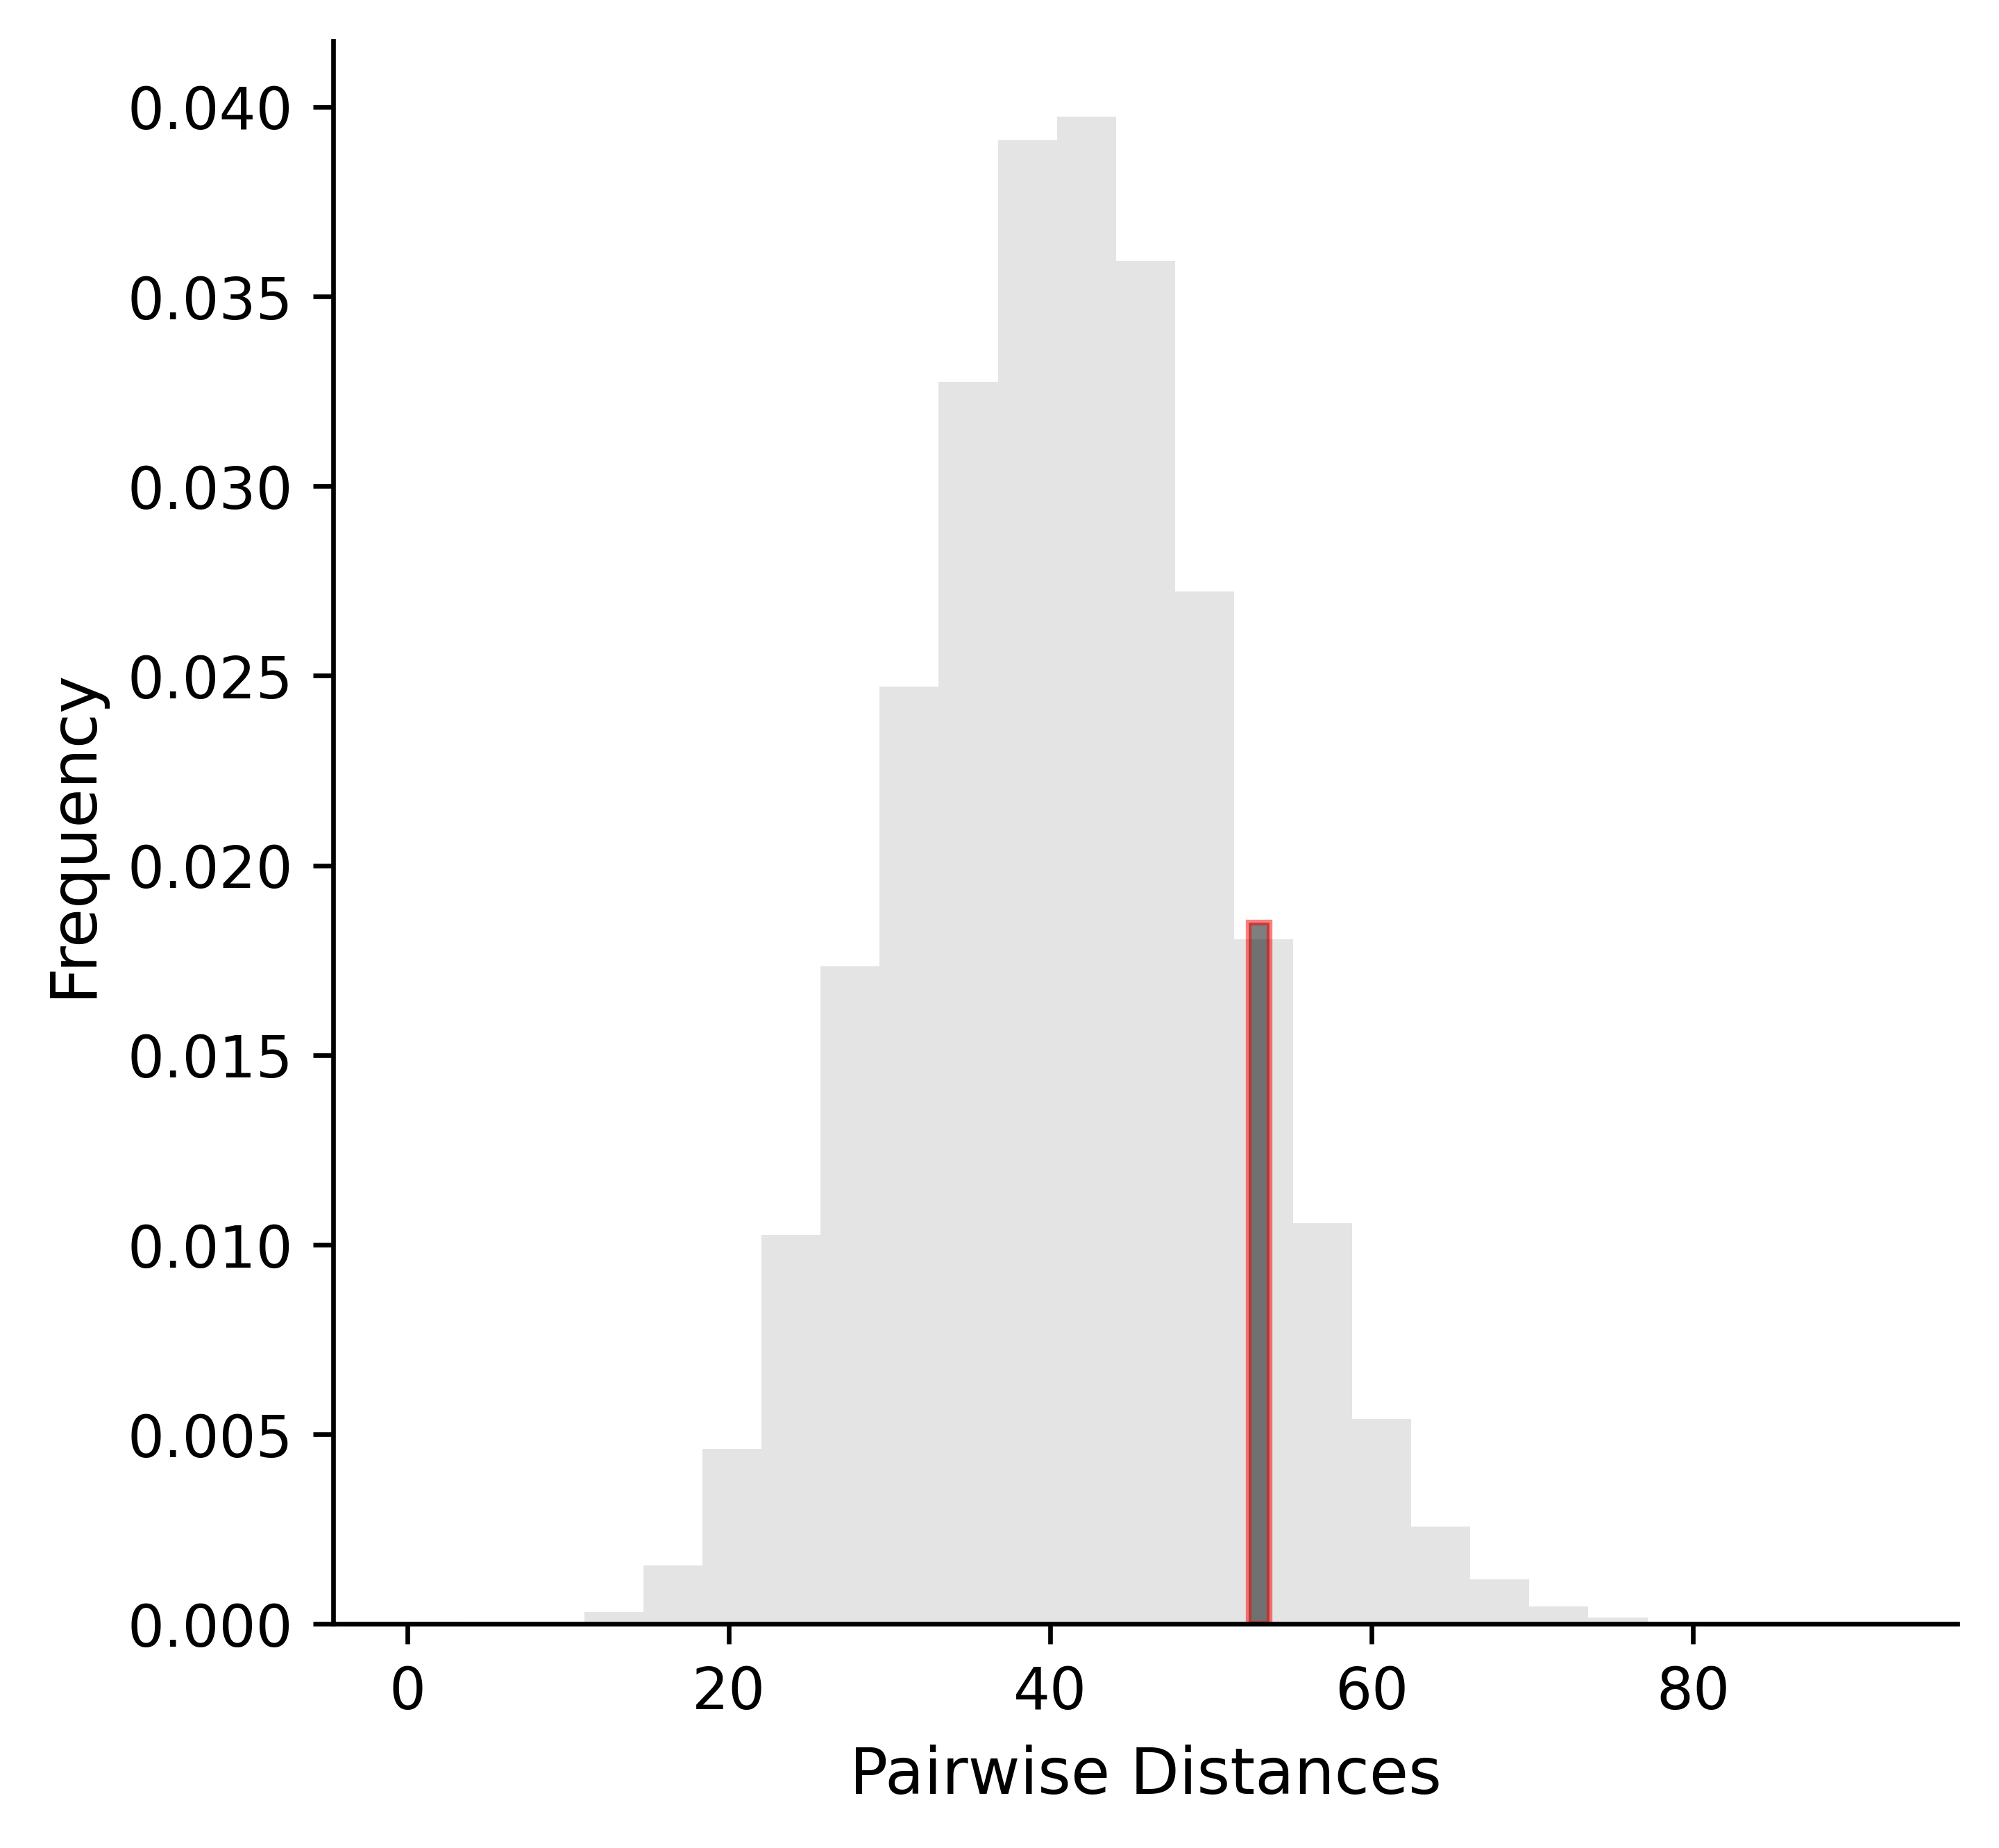

In [ ]:
plt.figure(figsize=(5,5),dpi=600)
plt.hist(sub_dists.flatten(),density=True,bins=25,alpha=0.6,color='lightgrey')

# Add the patch to the Axes
plt.gca().add_patch(Rectangle((53-std/thresh,0),2*(std/thresh),.0185,linewidth=1,edgecolor='red',facecolor='black',alpha=0.5))

plt.grid(None)
ax = plt.gca()

#Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
 
plt.xlabel("Pairwise Distances",fontsize=11)
plt.ylabel("Frequency",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

Create graph, find cliques, print stats

In [39]:
def getCliques(known_values):
  adjacency_matrix = known_values.astype(int)
  rows, cols = np.where(adjacency_matrix == 1)
  edges = zip(rows.tolist(), cols.tolist())
  gr = nx.Graph()
  all_rows = range(0, adjacency_matrix.shape[0])
  for n in all_rows:
    gr.add_node(n)

  gr.add_edges_from(edges)


  cliques = list(nx.find_cliques(gr))

  #Look at number of cells in cliques (sizes)
  print(np.unique([len(i) for i in cliques])) 

  print(len(cliques))

  return cliques

In [40]:
#cliques = getCliques(known_values)
cliques_low = getCliques(known_values_low)
cliques_high = getCliques(known_values_high)

[1 2 3 4 5 6 7 8 9]
1585715
[1 2 3 4 5 6 7 8 9]
1156826


In [41]:
#Equidistant Cliques with avg distance
cliques = getCliques(known_values)

[ 1  2  3  4  5  6  7  8  9 10]
4073075


Histogram of clique sizes (around avg pairwise distance) for cliques size 3 and greater

In [92]:
cliqueSizes = pd.DataFrame()
cliqueSizes['size'] = [len(i) for i in cliques_low]
cliqueSizes = cliqueSizes[cliqueSizes['size'] > 2]

print(len(cliqueSizes))

1511502


(array([     0., 100000., 200000., 300000., 400000., 500000., 600000.,
        700000., 800000.]), <a list of 9 Text major ticklabel objects>)

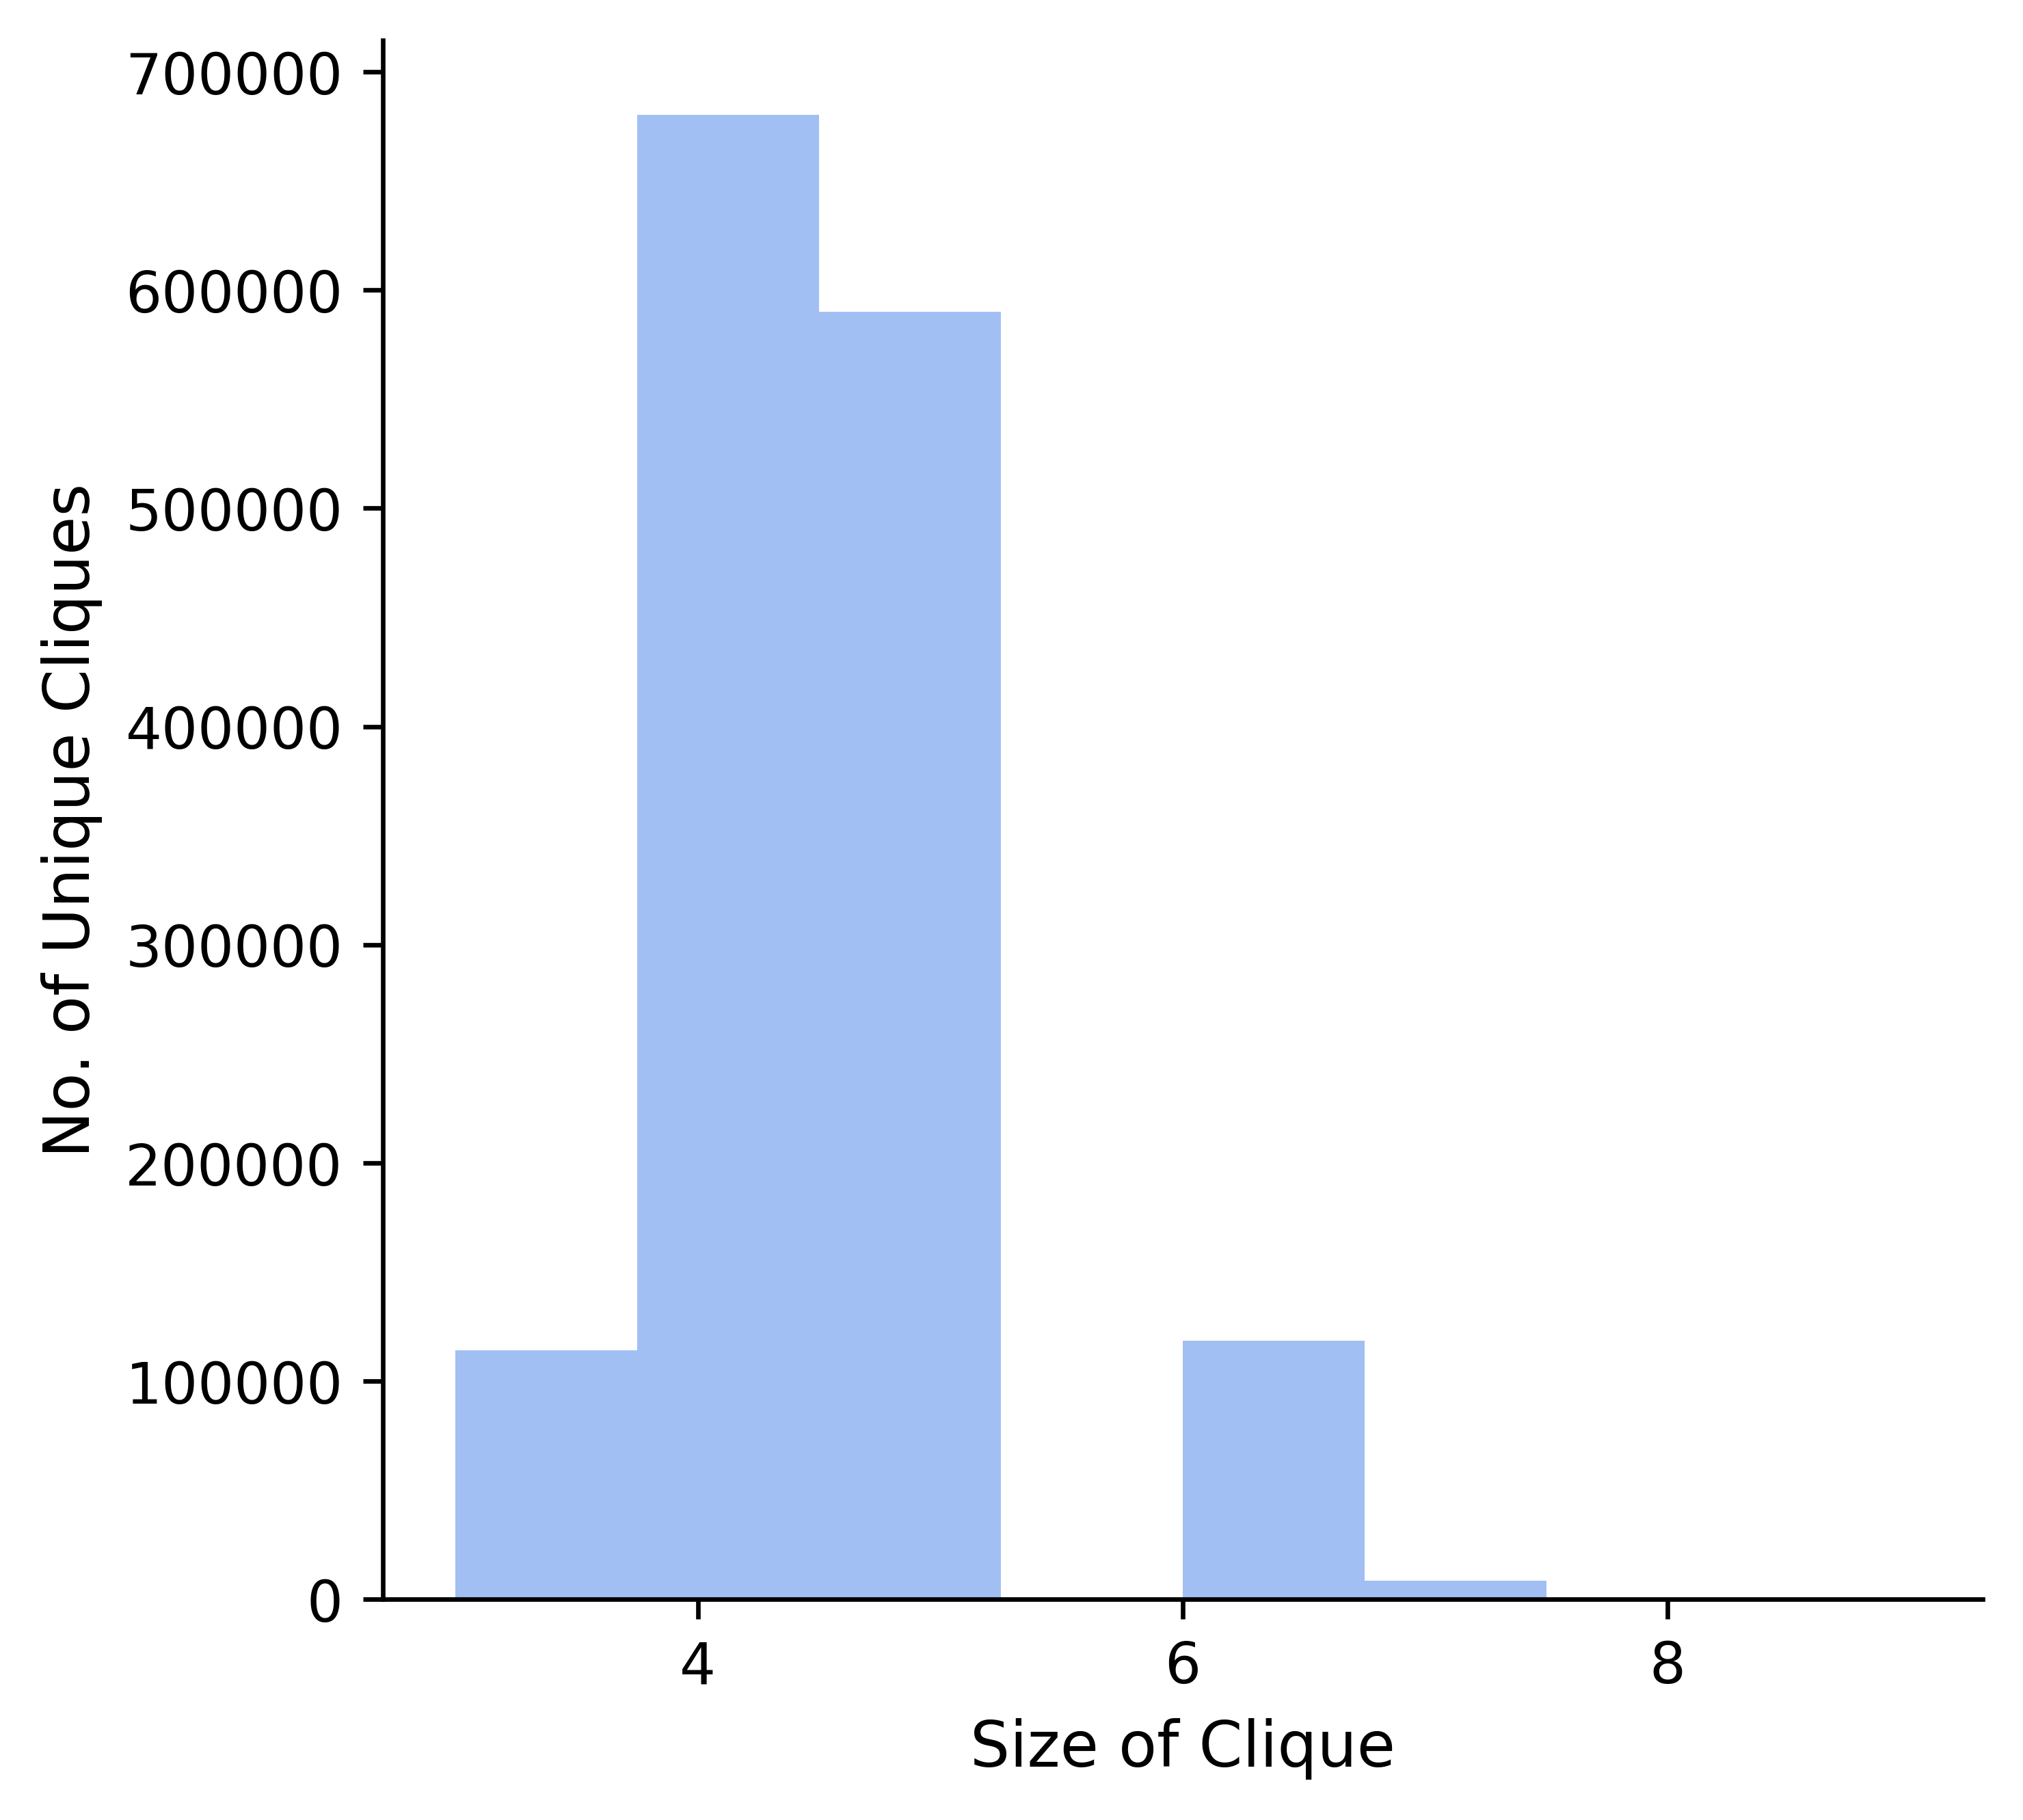

In [ ]:


plt.figure(figsize=(5,5),dpi=600)
plt.hist(list(cliqueSizes['size']),bins=8,alpha=0.6,color='cornflowerblue')

# Add the patch to the Axes

plt.grid(None)
ax = plt.gca()

#Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
 
plt.xlabel("Size of Clique",fontsize=11)
plt.ylabel("No. of Unique Cliques",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [ ]:
cliqueSizes = pd.DataFrame()
cliqueSizes['size'] = [len(i) for i in cliques_high]
cliqueSizes = cliqueSizes[cliqueSizes['size'] > 2]

print(len(cliqueSizes))

1020120


(array([     0., 100000., 200000., 300000., 400000., 500000.]),
 <a list of 6 Text major ticklabel objects>)

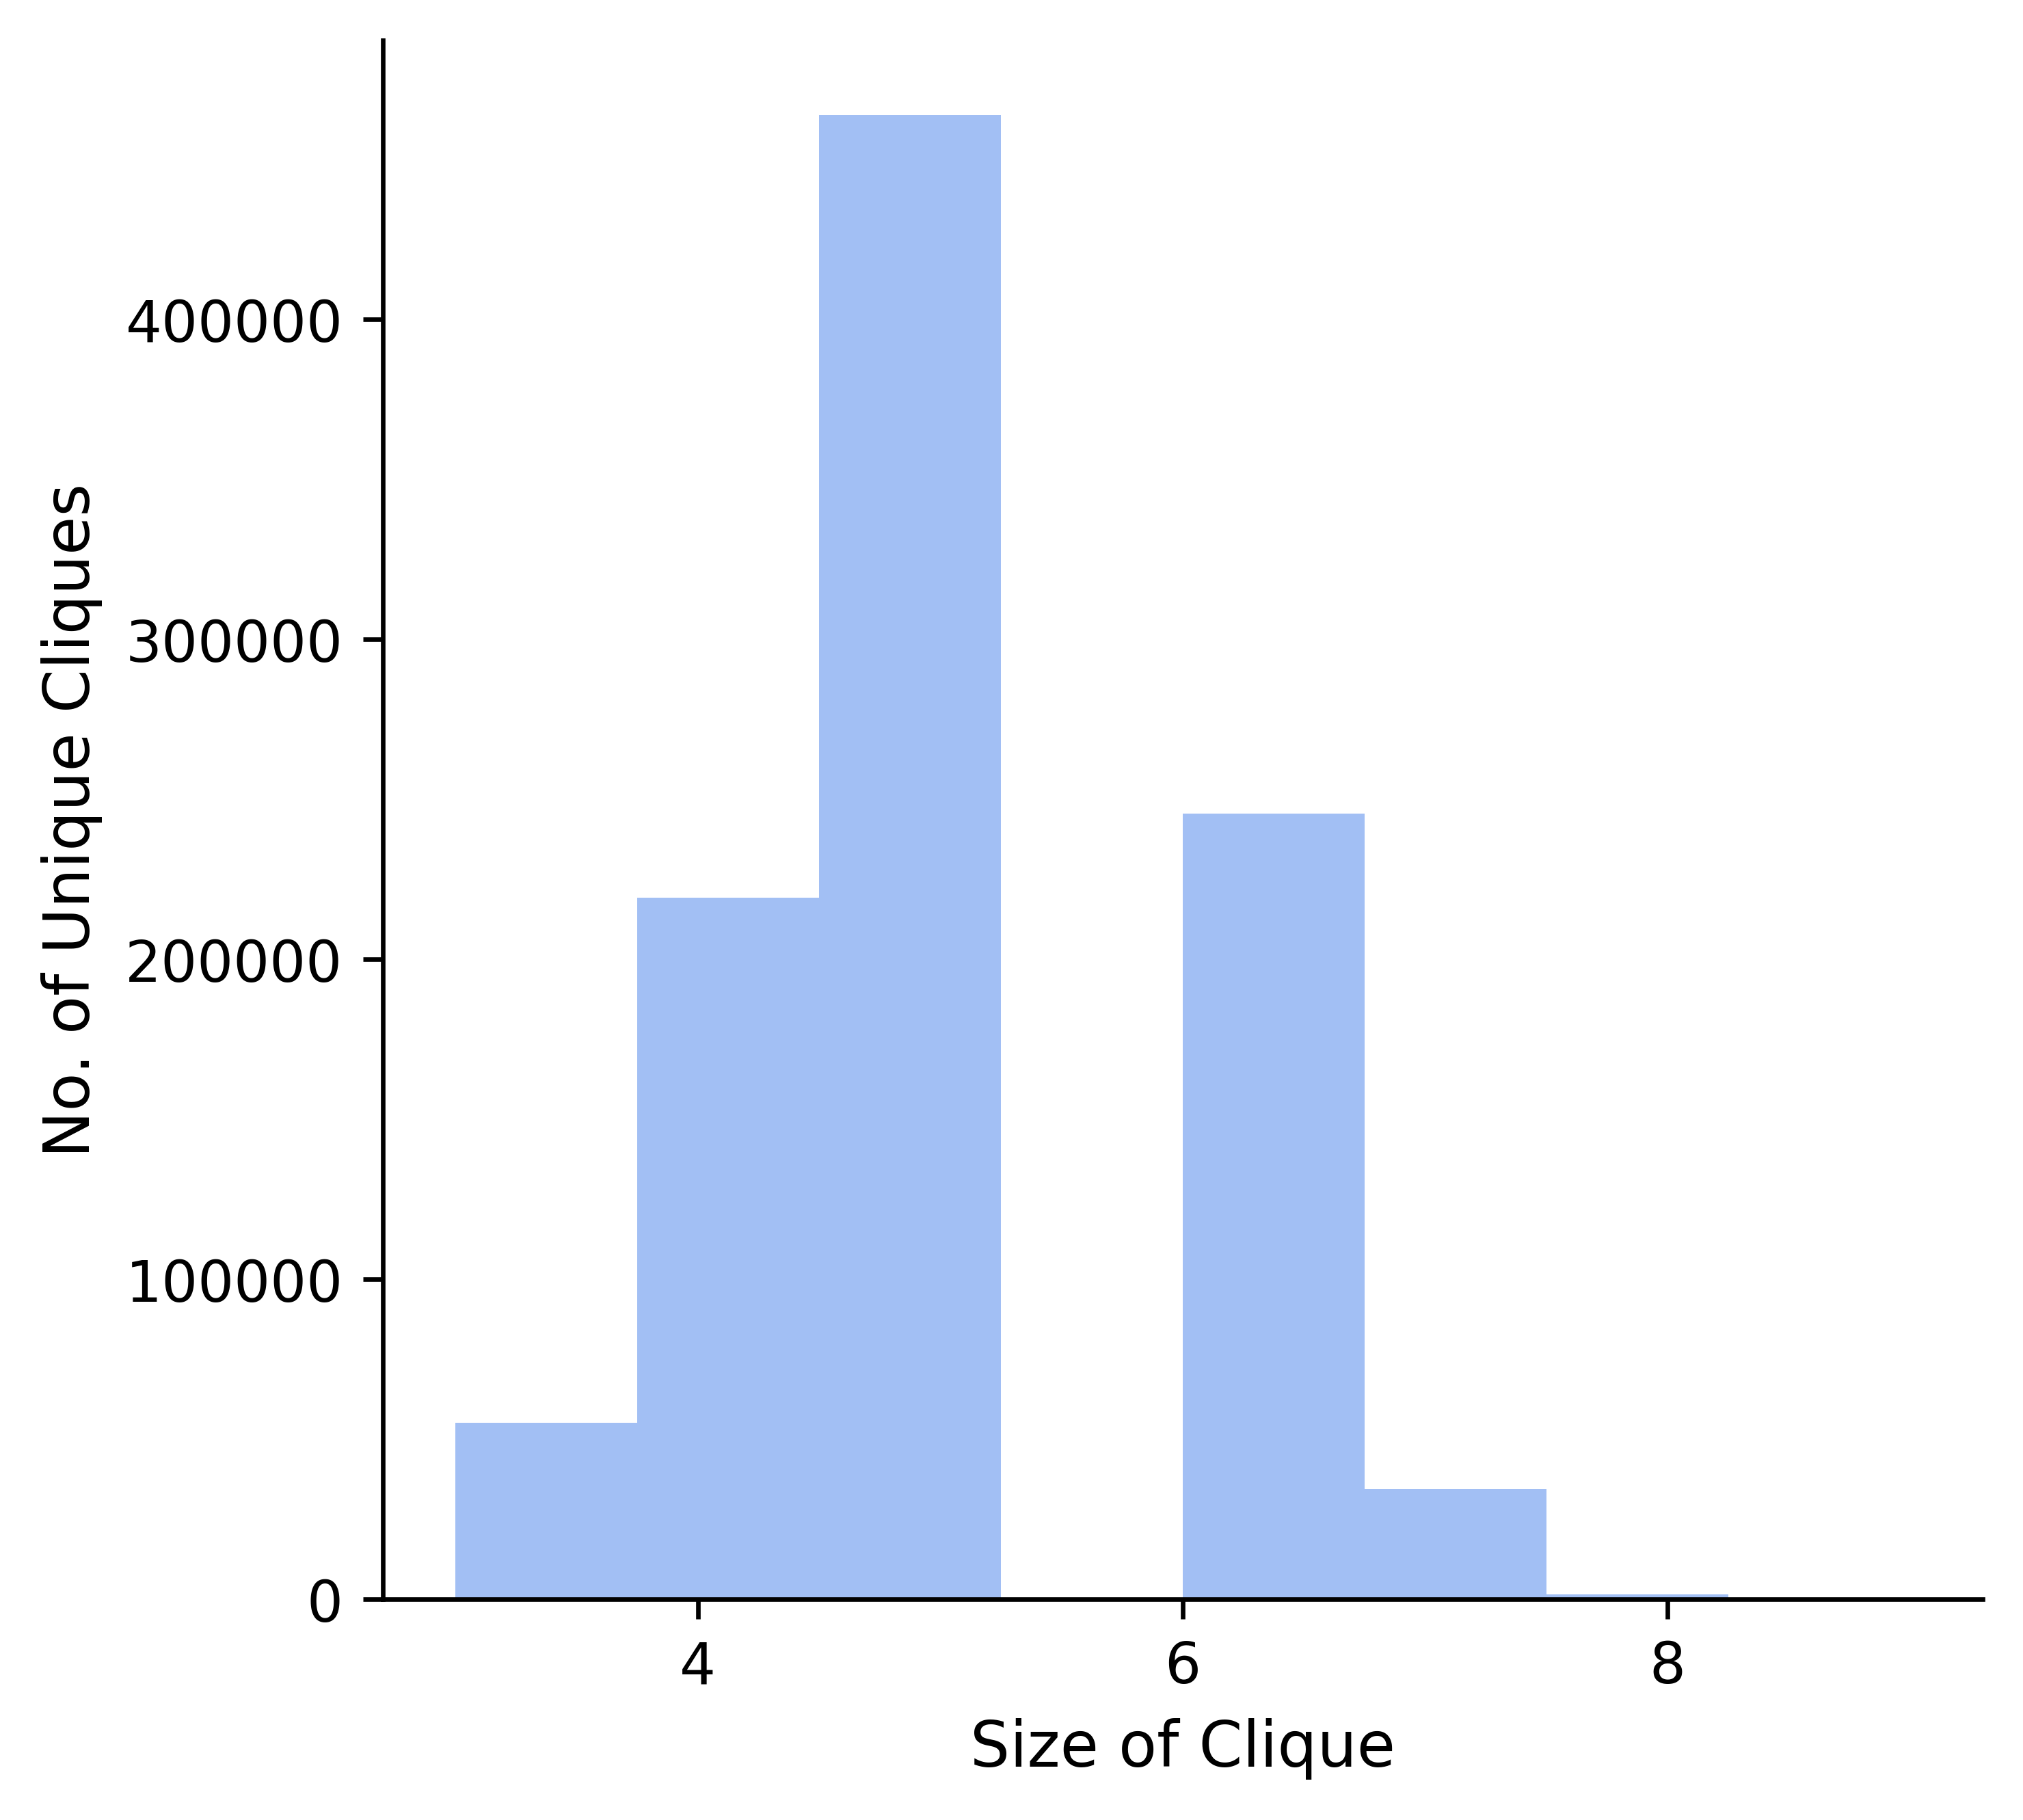

In [ ]:


plt.figure(figsize=(5,5),dpi=600)
plt.hist(list(cliqueSizes['size']),bins=8,alpha=0.6,color='cornflowerblue')

# Add the patch to the Axes

plt.grid(None)
ax = plt.gca()

#Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
 
plt.xlabel("Size of Clique",fontsize=11)
plt.ylabel("No. of Unique Cliques",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [ ]:
cliqueSizes = pd.DataFrame()
cliqueSizes['size'] = [len(i) for i in cliques]
cliqueSizes = cliqueSizes[cliqueSizes['size'] > 2]

print(len(cliqueSizes))

3763130


(array([      0.,  200000.,  400000.,  600000.,  800000., 1000000.,
        1200000., 1400000., 1600000., 1800000.]),
 <a list of 10 Text major ticklabel objects>)

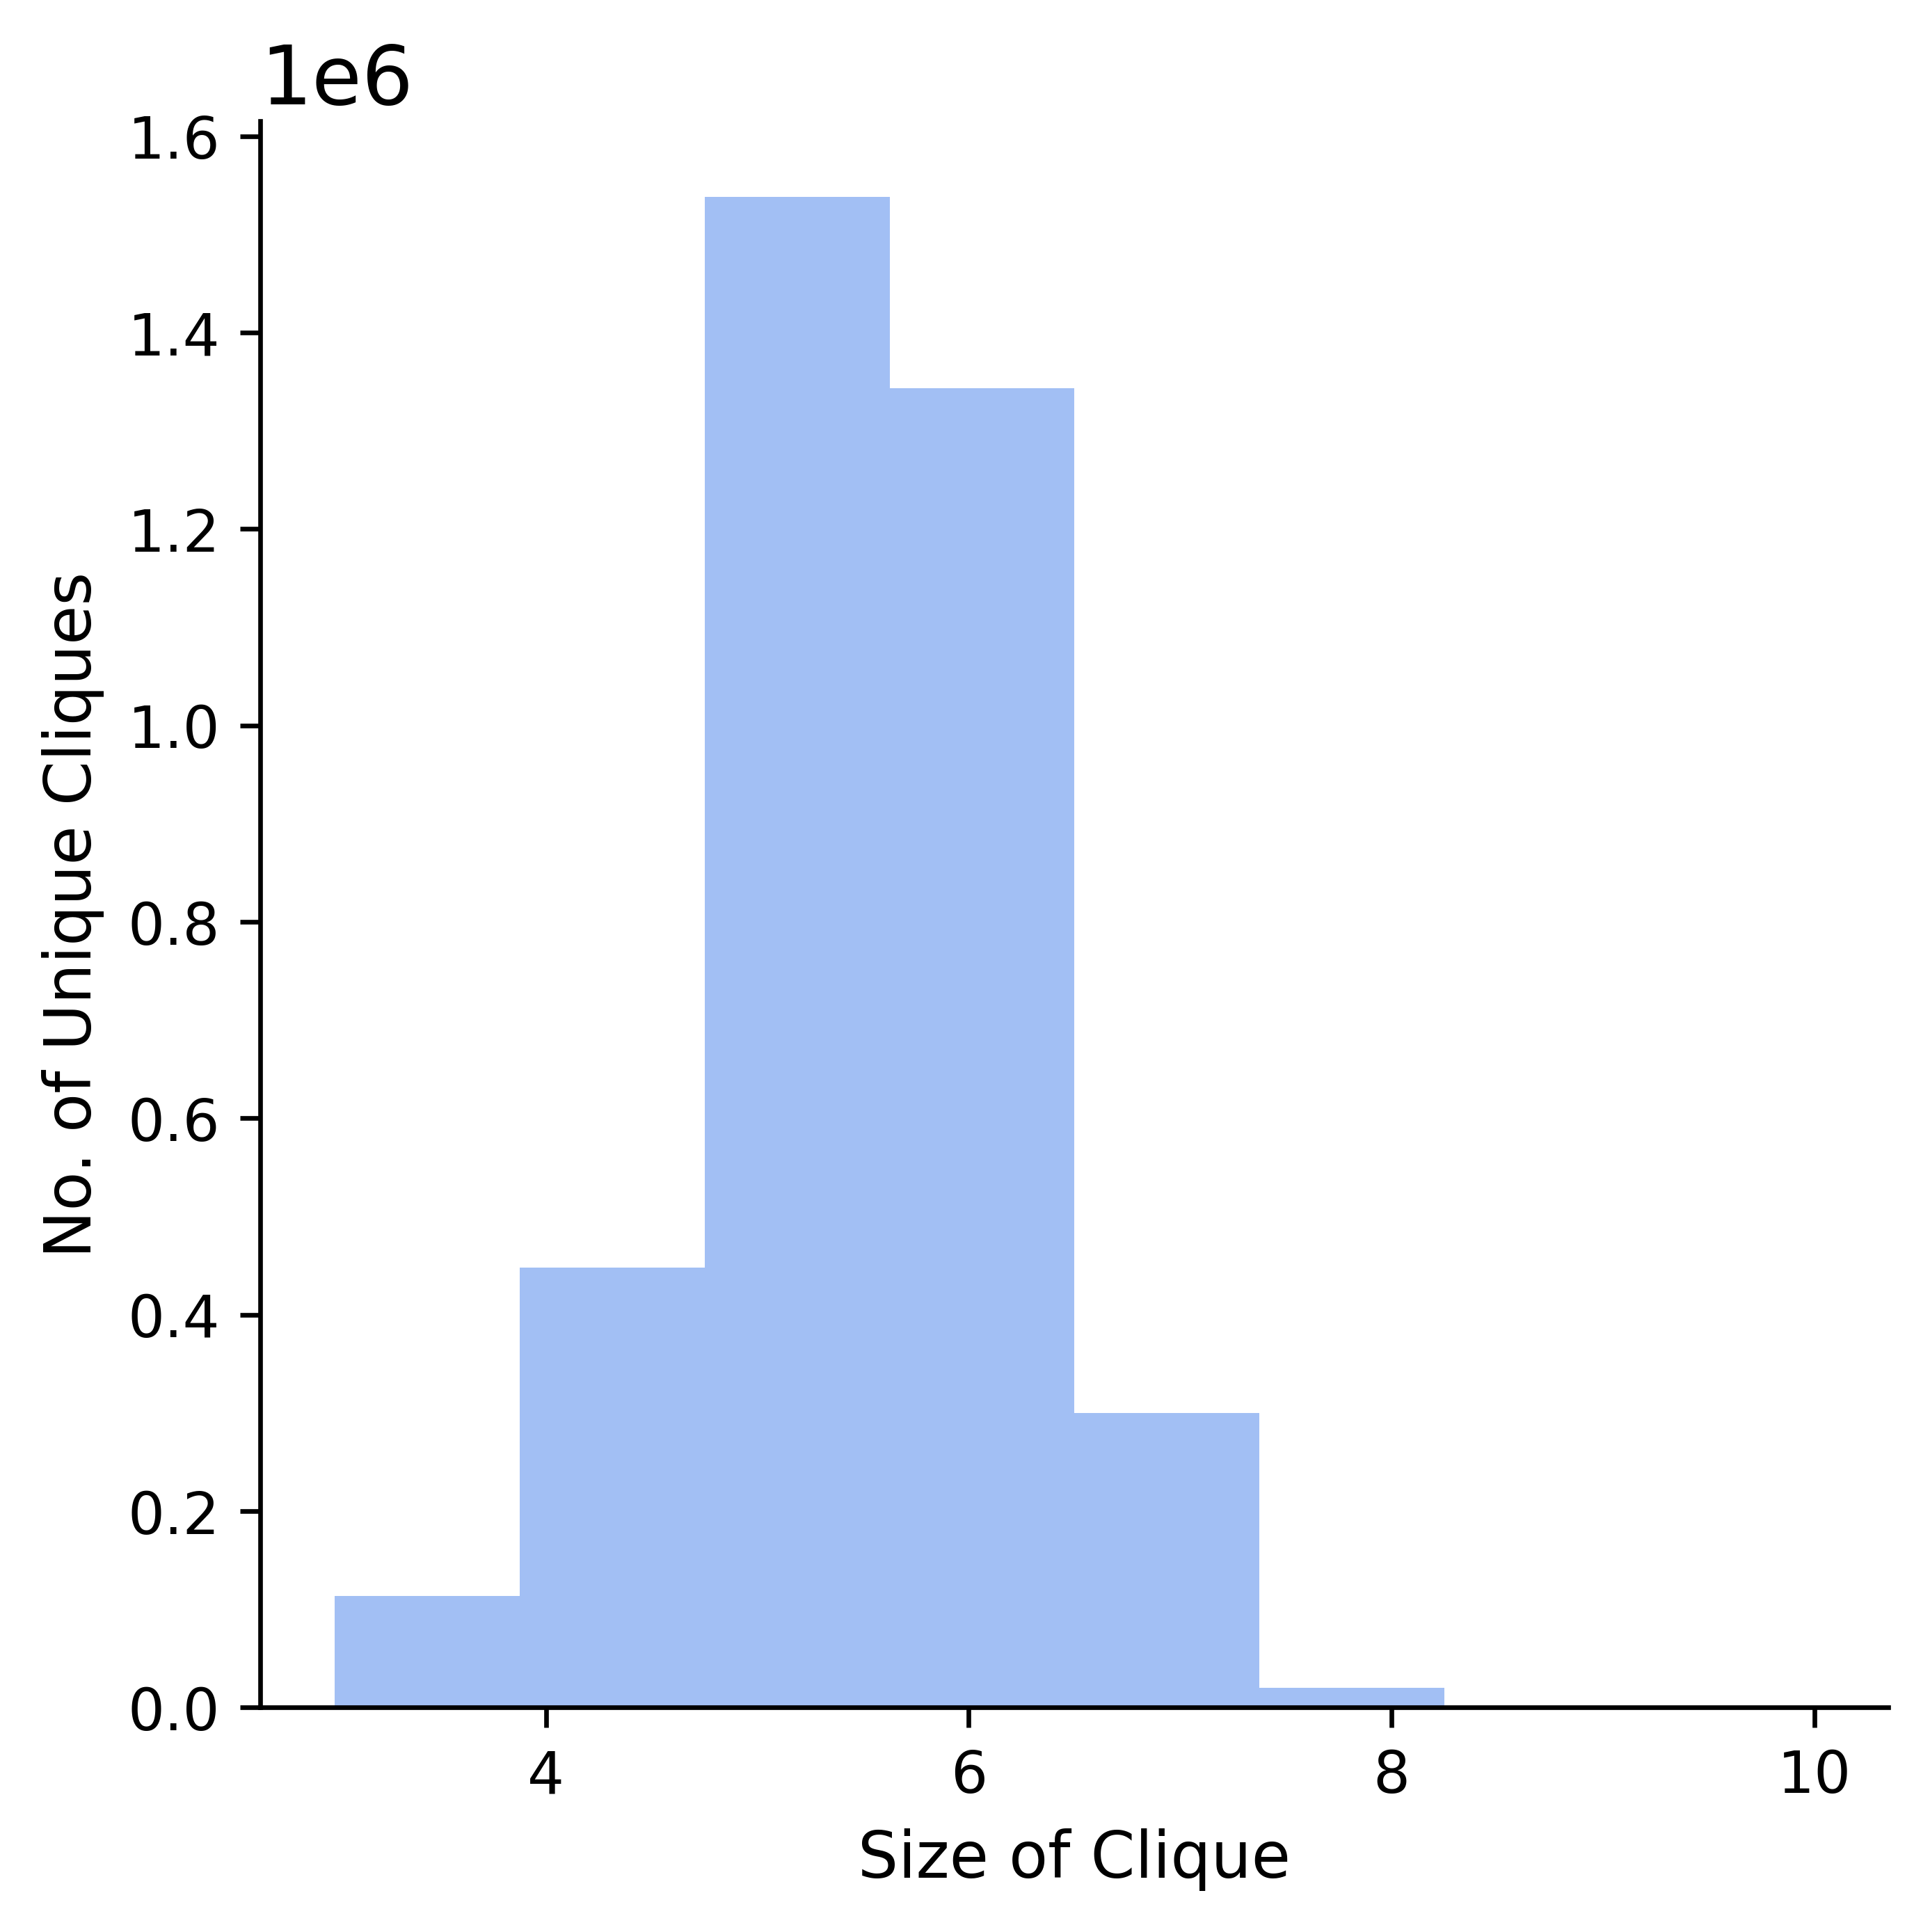

In [ ]:


plt.figure(figsize=(5,5),dpi=600)
plt.hist(list(cliqueSizes['size']),bins=8,alpha=0.6,color='cornflowerblue')

# Add the patch to the Axes

plt.grid(None)
ax = plt.gca()

#Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
 
plt.xlabel("Size of Clique",fontsize=11)
plt.ylabel("No. of Unique Cliques",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

### **Take cliques and compare variance in pairwise distances after dimensionality reduction**

In [42]:
#Get variance of pairwise distances between cells in given latent space
def getVar(latent,nodes):
  d = pairwise_distances(latent[nodes,:])
  d = d[d!=0]
  var = np.std(d)**2/np.mean(d)
  return var


In [43]:
#Get variance of pairwise distances between cells in given latent space
def getMaxMin(latent,nodes):
  d = pairwise_distances(latent[nodes,:])
  d = d[d!=0]
  ratio = np.max(d)/np.min(d)
  return ratio


In [44]:
#Get variance of pairwise distances between cell type centroids in given latent space
def getVarwithDist(dists,nodes):
  d = dists[nodes,:]
  d = d[:,nodes]
  d = d[d!=0]
  var = np.std(d)**2/np.mean(d)
  return var


In [45]:
#Get variance of pairwise distances between cells in given latent space
def getMaxMinwithDist(dists,nodes):
  d = dists[nodes,:]
  d = d[:,nodes]
  d = d[d!=0]
  ratio = np.max(d)/np.min(d)
  return ratio


In [46]:
#Get nonzero gene indices (which genes do the cliques express)
def getNonzero(latent,nodes):
  d = np.nonzero(np.any(latent[nodes,:] != 0, axis=0))[0]
  return d.tolist()

In [47]:
def getNeighMaxMin(latent,neighbors=10):
  n = neighbors
  neigh = NearestNeighbors(n_neighbors=n)
  neigh.fit(latent)

  #Get nearest neighbors for each cell
  kNeigh = neigh.kneighbors(latent)
  matNeigh = kNeigh[1]

  return matNeigh

Subset cliques because there are a lot of them

In [48]:
cliquesSub = [i for i in cliques if len(i) >= 8] #8
len(cliquesSub)

20423

In [49]:
cliquesSubLow = [i for i in cliques_low if len(i) >= 7] #8
len(cliquesSubLow)

8824

In [50]:
cliquesSubHigh = [i for i in cliques_high if len(i) >= 7] #8
len(cliquesSubHigh)

36035

In [51]:
# cliquesSub = cliques[5000:10000]

Get variances and min/max ratios for ambient and latent spaces for cliques

In [52]:
def getCliqueDF(cliquesSub):
  ambVars = [np.mean([getVar(sub_mat,i) for i in cliquesSub])]

  #Get variances of pairwise distances
  latVars = []
  latLabs = []

  for l in range(len(latents)):
    latVars += [np.mean([getVar(sublatents[l],i) for i in cliquesSub])]
    latLabs += [latentLab[l]]

  latVars += ambVars
  latLabs += ['Integrated-Scaled Ambient']

  #Get max/min ratio of pairwise distances
  ambVarsRatio = [np.mean([getMaxMin(sub_mat,i) for i in cliquesSub])]

  latVarsRatio = []
  latLabsRatio = []

  for l in range(len(latents)):
    latVarsRatio += [np.mean([getMaxMin(sublatents[l],i) for i in cliquesSub])]

  latVarsRatio += ambVarsRatio



  #Get max/min for cell + 10 NNs (nearest neighbors) in ambient versus latent spaces
  matNeigh = getNeighMaxMin(sub_mat,neighbors=10)
  ambVarsRatioKNN = [np.mean([getMaxMin(sub_mat,i) for i in matNeigh])]


  latVarsRatioKNN = []
  latLabsRatioKNN = []

  for l in range(len(latents)):
    matNeigh = getNeighMaxMin(sublatents[l],neighbors=10) #Could also try with the same NNs as in ambient space
    latVarsRatioKNN += [np.mean([getMaxMin(sublatents[l],i) for i in matNeigh])]

  latVarsRatioKNN += ambVarsRatioKNN

  res = pd.DataFrame()
  res['Vars'] = latVars
  res['Embed'] = latLabs
  res['LogVars'] = np.log(res['Vars'])
  res['Ratio'] = latVarsRatio
  res['RatioKNN'] = latVarsRatioKNN
  return res

#### **Look at distortion by PCA, t-SNE/UMAP, and PCA-tSNE/UMAP**

In [53]:
#Get latent spaces for comparison to ambient
latents,latentLab,latentType = latentDistortComp(scaled_mat, ndims=2, pcs=[15,50,100], rounds = 3)


In [54]:

sublatents = [i[adata.obs['Cluster'].isin([clus]),:] for i in latents]




resUt = getCliqueDF(cliquesSub)
resUt.head()

,Vars,Embed,LogVars,Ratio,RatioKNN
0,0.925687,PCA 15D,-0.077220,4.548433,2.829278
1,10.702757,PCA 15D t-SNE,2.370501,34.443367,24.944498
2,0.564349,PCA 15D UMAP,-0.572082,23.493973,20.979410
3,0.644038,PCA 50D,-0.439997,2.512758,2.560746
4,2.847382,PCA 50D t-SNE,1.046400,17.828094,23.102537


In [55]:
resUt.to_csv('distortUtE105.csv')

